# Amazon SageMaker Object Detection using the RecordIO format

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Data Preparation](#Data-Preparation)
  1. [Download data](#Download-Data)
  2. [Convert data into RecordIO](#Convert-data-into-RecordIO)
  3. [Upload to S3](#Upload-to-S3)
4. [Training](#Training)
5. [Hosting](#Hosting)
6. [Inference](#Inference)

## Introduction

Object detection is the process of identifying and localizing objects in an image. A typical object detection solution takes in an image as input and provides a bounding box on the image where a object of interest is along with identifying what object the box encapsulates. But before we have this solution, we need to acquire and process a traning dataset, create and setup a training job for the alorithm so that the aglorithm can learn about the dataset and then host the algorithm as an endpoint, to which we can supply the query image.

This notebook is an end-to-end example introducing the Amazon SageMaker Object Detection algorithm. In this demo, we will demonstrate how to train and to host an object detection model on the [Pascal VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/) using the Single Shot multibox Detector ([SSD](https://arxiv.org/abs/1512.02325)) algorithm. In doing so, we will also demonstrate how to construct a training dataset using the RecordIO format as this is the format that the training job will consume. We will also demonstrate how to host and validate this trained model. Amazon SageMaker Object Detection also allow training with the image and JSON format, which is illustrated in the [image and JSON Notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_image_json_format.ipynb).

## Setup

To train the Object Detection algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with we need an AWS account role with SageMaker access. This role is used to give SageMaker access to your data in S3 will automatically be obtained from the role used to start the notebook.

In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
sess = sagemaker.Session()

CPU times: user 696 ms, sys: 164 ms, total: 860 ms
Wall time: 838 ms


We also need the S3 bucket that you want to use for training and to store the tranied model artifacts. In this notebook, we require a custom bucket that exists so as to keep the naming clean. You can end up using a default bucket that SageMaker comes with as well.

In [2]:
bucket = 'object-detection-data-pepsi' # custom bucket name.
# bucket = sess.default_bucket() 
prefix = 'pepsi'

Lastly, we need the Amazon SageMaker Object Detection docker image, which is static and need not be changed.

In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")

In [4]:
def get_object_boundary_box(img, obj_boundaries):
    if (len(obj_boundaries) != 4):
        raise Exception("Sagemaker boundaries are not of size 4")
    # Find size of boundary box 
    img_boundaries = img.getbbox()
    x_size = img_boundaries[2] - img_boundaries[0]
    y_size = img_boundaries[3] - img_boundaries[1]

    # Generate tuple of pixel boundaries using the boundaries generated from model. 
    x_min = floor(x_size * obj_boundaries[0])
    y_min = floor(y_size * obj_boundaries[1])
    x_max = ceil(x_size * obj_boundaries[2])
    y_max = ceil(y_size * obj_boundaries[3])
    return tuple(map(int, [x_min, y_min, x_max, y_max]))

In [5]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

In [6]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    
    #print(bb1[0])
    #bb1 = float(bb1)
    #bb2 = float(bb2)
    #print(bb1)
    
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    
    if intersection_area == bb1_area or intersection_area == bb1_area:
        return 1.0
    
    if intersection_area / bb1_area > 0.5  or intersection_area / bb2_area > 0.5:
        return 0.5

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

## Data Preparation
[Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) was a popular computer vision challenge and they released annual challenge datasets for object detection from 2005 to 2012. In this notebook, we will use the data sets from 2007 and 2012, named as VOC07 and VOC12 respectively. Cumulatively, we have more than 20,000 images containing about 50,000 annotated objects. These annotated objects are grouped into 20 categories.

While using the Pascal VOC dateset, please be aware of the database usage rights:
"The VOC data includes images obtained from the "flickr" website. Use of these images must respect the corresponding terms of use: 
* "flickr" terms of use (https://www.flickr.com/help/terms)"

### Download data
Let us download the Pascal VOC datasets from 2007 and 2012.

### Convert data into RecordIO
[RecordIO](https://mxnet.incubator.apache.org/architecture/note_data_loading.html) is a highly efficient binary data format from [MXNet](https://mxnet.incubator.apache.org/) that makes it easy and simple to prepare the dataset and transfer to the instance that will run the training job. To generate a RecordIO file, we will use the tools from MXNet. The provided tools will first generate a list file and then use the [im2rec tool](https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py) to create the [RecordIO](https://mxnet.incubator.apache.org/architecture/note_data_loading.html) file. More details on how to generate RecordIO file for object detection task, see the [MXNet example](https://github.com/apache/incubator-mxnet/tree/master/example/ssd).

We will combine the training and validation sets from both 2007 and 2012 as the training data set, and use the test set from 2007 as our validation set.

Along with this notebook, we have provided tools that can directly generate the RecordIO files so that you do not need to do addtional work. These tools work with the Pascal datasets lst format, which is also quite the common among most datasets. If your data are stored in a different format or the annotation of your data is in a different format than the Pascal VOC dataset, you can also create the RecordIO by first generating the .lst file and then using the im2rec tool provided by MXNet. To make things clear, we will explain the definition of a .lst file so that you can prepare it in your own way. The following example is the first three lines of the .lst file we just generated for the Pascal VOC dataset.

As can be seen that each line in the .lst file represents the annotations for a image. A .lst file is a **tab**-delimited file with multiple columns. The rows of the file are annotations of the of image files. The first column specifies a unique image index. The second column specifies the header size of the current row. In the above example .lst file, 2 from the second column means the second and third columns are header information, which will not be considered as label and bounding box information of the image specified by the current row.

The third column specifies the label width of a single object. In the first row of above sample .lst file, 5 from the third row means each object within an image will have 5 numbers to describe its label information, including class index, and bounding box coordinates. If there are multiple objects within one image, all the label information should be listed in one line. The annotation information for each object is represented as ``[class_index, xmin, ymin, xmax, ymax]``. 

The classes should be labeled with successive numbers and start with 0. The bounding box coordinates are ratios of its top-left (xmin, ymin) and bottom-right (xmax, ymax) corner indices to the overall image size. Note that the top-left corner of the entire image is the origin (0, 0). The last column specifies the relative path of the image file.

After generating the .lst file, the RecordIO can be created by running the following command:

### Upload data to S3
Upload the data to the S3 bucket. We do this in multiple channels. Channels are simply directories in the bucket that differentiate between training and validation data. Let us simply call these directories `train` and `validation`.

In [7]:
%%time

# Upload the RecordIO files to train and validation channels
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

# sess.upload_data(path='train.rec', bucket=bucket, key_prefix=train_channel)
# sess.upload_data(path='val.rec', bucket=bucket, key_prefix=validation_channel)

# sess.upload_data(path='train_rec.rec', bucket=bucket, key_prefix=train_channel)
# sess.upload_data(path='val_rec.rec', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.54 µs


Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's traning job.

In [8]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

## Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

In [9]:
# od_model = sagemaker.estimator.Estimator(training_image,
#                                          role, 
#                                          train_instance_count=1, 
#                                          train_instance_type='ml.p2.xlarge',
# #                                          train_instance_type='ml.m4.16xlarge',
#                                          train_volume_size = 50,
#                                          train_max_run = 360000,
#                                          input_mode= 'File',
#                                          output_path=s3_output_location,
#                                          sagemaker_session=sess)

od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=2, 
                                         train_instance_type='ml.p3.16xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

The object detection algorithm at its core is the [Single-Shot Multi-Box detection algorithm (SSD)](https://arxiv.org/abs/1512.02325). This algorithm uses a `base_network`, which is typically a [VGG](https://arxiv.org/abs/1409.1556) or a [ResNet](https://arxiv.org/abs/1512.03385). The Amazon SageMaker object detection algorithm supports VGG-16 and ResNet-50 now. It also has a lot of options for hyperparameters that help configure the training job. The next step in our training, is to setup these hyperparameters and data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Object Detection [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html) for more details on the hyperparameters.

One of the hyperparameters here for instance is the `epochs`. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm. For the sake of demonstration let us run only `10` epochs. Based on our tests, train the model for `30` epochs with similar settings should give us reasonable detection results on the Pascal VOC data.

In [10]:
# od_model.set_hyperparameters(base_network='resnet-50',
#                              use_pretrained_model=1,
#                              num_classes=15,
#                              mini_batch_size=10,
#                              epochs=30,
#                              learning_rate=0.001,
#                              lr_scheduler_step='3,6',
#                              lr_scheduler_factor=0.1,
#                              optimizer='sgd',
#                              momentum=0.9,
#                              weight_decay=0.0005,
#                              overlap_threshold=0.5,
#                              nms_threshold=0.45,
#                              image_shape=300,
#                              label_width=350,
#                              num_training_samples=68)

od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes= 2,
                             mini_batch_size=64,
                             epochs=600,
                             learning_rate=0.001,
                             lr_scheduler_step='320,640',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.98,
                             weight_decay=0.00015,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=512,
                             label_width=350,
                             num_training_samples=5000)

# learning_rate=0.0005, image_shape=512 and mini_batch_size=16 for 240 epochs.

Now that the hyperparameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [11]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='application/x-recordio', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='application/x-recordio', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

We have our `Estimator` object, we have set the hyperparameters for this object and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instances that we requested while creating the `Estimator` classes are provisioned and are setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take time, depending on the size of the data. Therefore it might be a few minutes before we start getting data logs for our training jobs. The data logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset once or one epoch. This metric is a proxy for the quality of the algorithm. 

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [ ]:
od_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: object-detection-2019-01-01-20-28-05-975


2019-01-01 20:28:06 Starting - Starting the training job...
Launching requested ML instances.........
Preparing the instances for training.........
2019-01-01 20:31:15 Downloading - Downloading input data........
Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
[01/01/2019 20:32:45 INFO 140541334759232] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_training_samples': u'', u'optimizer': u'sgd', u'_tuning_objective_metric': u'', u'early_stopping_tolerance': u'0.0', u'learning_rate': u'


2019-01-01 20:32:38 Training - Training image download completed. Training in progress.[01/01/2019 20:32:57 INFO 140036530603840] done loading checkpoint
[20:32:59] /opt/brazil-pkg-cache/packages/MXNetECL/MXNetECL-master.349.0/AL2012/generic-flavor/src/src/io/iter_image_det_recordio.cc:334: ImageDetRecordIOParser: /opt/ml/input/data/train/train.rec, label padding width: 350
[01/01/2019 20:33:03 WARNING 140541334759232] Validation images are resized to image shape (3, 512, 512)
[20:33:03] /opt/brazil-pkg-cache/packages/MXNetECL/MXNetECL-master.349.0/AL2012/generic-flavor/src/src/io/iter_image_det_recordio.cc:281: ImageDetRecordIOParser: /opt/ml/input/data/validation/val.rec, use 32 threads for decoding..
[20:33:06] /opt/brazil-pkg-cache/packages/MXNetECL/MXNetECL-master.349.0/AL2012/generic-flavor/src/src/io/iter_image_det_recordio.cc:334: ImageDetRecordIOParser: /opt/ml/input/data/validation/val.rec, label padding width: 350
[01/01/2019 20:33:08 INFO 140541334759232] Creating new stat

[01/01/2019 20:35:38 INFO 140036530603840] #quality_metric: host=algo-2, epoch=1, batch=39 train cross_entropy <loss>=(1.05100294087)
[01/01/2019 20:35:38 INFO 140036530603840] #quality_metric: host=algo-2, epoch=1, batch=39 train smooth_l1 <loss>=(0.400689534371)
[01/01/2019 20:35:38 INFO 140036530603840] Round of batches complete
[01/01/2019 20:35:39 INFO 140036530603840] Updated the metrics
[01/01/2019 20:35:42 INFO 140036530603840] #quality_metric: host=algo-2, epoch=1, validation mAP <score>=(0.938202802437)
[01/01/2019 20:35:42 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 20:35:42 INFO 140036530603840] #progress_metric: host=algo-2, completed 0 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"

[01/01/2019 20:39:04 INFO 140036530603840] #quality_metric: host=algo-2, epoch=4, batch=39 train cross_entropy <loss>=(0.505582985255)
[01/01/2019 20:39:04 INFO 140036530603840] #quality_metric: host=algo-2, epoch=4, batch=39 train smooth_l1 <loss>=(0.199873836009)
[01/01/2019 20:39:04 INFO 140036530603840] Round of batches complete
[01/01/2019 20:39:05 INFO 140541334759232] #quality_metric: host=algo-1, epoch=4, batch=39 train cross_entropy <loss>=(0.493464296502)
[01/01/2019 20:39:05 INFO 140541334759232] #quality_metric: host=algo-1, epoch=4, batch=39 train smooth_l1 <loss>=(0.184395102879)
[01/01/2019 20:39:05 INFO 140541334759232] Round of batches complete
[01/01/2019 20:39:05 INFO 140036530603840] Updated the metrics
[01/01/2019 20:39:06 INFO 140541334759232] Updated the metrics
[01/01/2019 20:39:09 INFO 140036530603840] #quality_metric: host=algo-2, epoch=4, validation mAP <score>=(0.990824110743)
[01/01/2019 20:39:09 INFO 140036530603840] No model is serialized on a non-master 

[01/01/2019 20:42:29 INFO 140541334759232] #quality_metric: host=algo-1, epoch=7, batch=39 train cross_entropy <loss>=(0.367105273515)
[01/01/2019 20:42:29 INFO 140541334759232] #quality_metric: host=algo-1, epoch=7, batch=39 train smooth_l1 <loss>=(0.137026681046)
[01/01/2019 20:42:29 INFO 140541334759232] Round of batches complete
[01/01/2019 20:42:29 INFO 140541334759232] Updated the metrics
[01/01/2019 20:42:32 INFO 140036530603840] #quality_metric: host=algo-2, epoch=7, batch=39 train cross_entropy <loss>=(0.36422548124)
[01/01/2019 20:42:32 INFO 140036530603840] #quality_metric: host=algo-2, epoch=7, batch=39 train smooth_l1 <loss>=(0.132588146668)
[01/01/2019 20:42:32 INFO 140036530603840] Round of batches complete
[01/01/2019 20:42:32 INFO 140541334759232] #quality_metric: host=algo-1, epoch=7, validation mAP <score>=(0.991622511728)
[01/01/2019 20:42:32 INFO 140541334759232] #progress_metric: host=algo-1, completed 1 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between 

[01/01/2019 20:45:47 INFO 140541334759232] #quality_metric: host=algo-1, epoch=10, batch=39 train cross_entropy <loss>=(0.329058790221)
[01/01/2019 20:45:47 INFO 140541334759232] #quality_metric: host=algo-1, epoch=10, batch=39 train smooth_l1 <loss>=(0.105957316377)
[01/01/2019 20:45:47 INFO 140541334759232] Round of batches complete
[01/01/2019 20:45:48 INFO 140541334759232] Updated the metrics
[01/01/2019 20:45:52 INFO 140541334759232] #quality_metric: host=algo-1, epoch=10, validation mAP <score>=(0.993602347494)
[01/01/2019 20:45:52 INFO 140541334759232] #progress_metric: host=algo-1, completed 1 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max"

[01/01/2019 20:49:08 INFO 140541334759232] #quality_metric: host=algo-1, epoch=13, batch=39 train cross_entropy <loss>=(0.301441896006)
[01/01/2019 20:49:08 INFO 140541334759232] #quality_metric: host=algo-1, epoch=13, batch=39 train smooth_l1 <loss>=(0.0881098337268)
[01/01/2019 20:49:08 INFO 140541334759232] Round of batches complete
[01/01/2019 20:49:09 INFO 140541334759232] Updated the metrics
[01/01/2019 20:49:12 INFO 140541334759232] #quality_metric: host=algo-1, epoch=13, validation mAP <score>=(0.993912619473)
[01/01/2019 20:49:12 INFO 140541334759232] #progress_metric: host=algo-1, completed 2 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max

[01/01/2019 20:52:25 INFO 140541334759232] #quality_metric: host=algo-1, epoch=16, batch=39 train cross_entropy <loss>=(0.288732605415)
[01/01/2019 20:52:25 INFO 140541334759232] #quality_metric: host=algo-1, epoch=16, batch=39 train smooth_l1 <loss>=(0.0819462713653)
[01/01/2019 20:52:25 INFO 140541334759232] Round of batches complete
[01/01/2019 20:52:26 INFO 140541334759232] Updated the metrics
[01/01/2019 20:52:29 INFO 140541334759232] #quality_metric: host=algo-1, epoch=16, validation mAP <score>=(0.993632155533)
[01/01/2019 20:52:29 INFO 140541334759232] #progress_metric: host=algo-1, completed 2 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max

[01/01/2019 20:55:46 INFO 140541334759232] #quality_metric: host=algo-1, epoch=19, batch=39 train cross_entropy <loss>=(0.276623920197)
[01/01/2019 20:55:46 INFO 140541334759232] #quality_metric: host=algo-1, epoch=19, batch=39 train smooth_l1 <loss>=(0.080227433407)
[01/01/2019 20:55:46 INFO 140541334759232] Round of batches complete
[01/01/2019 20:55:47 INFO 140541334759232] Updated the metrics
[01/01/2019 20:55:50 INFO 140541334759232] #quality_metric: host=algo-1, epoch=19, validation mAP <score>=(0.993734236129)
[01/01/2019 20:55:50 INFO 140541334759232] #progress_metric: host=algo-1, completed 3 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max"

[01/01/2019 20:59:04 INFO 140541334759232] #quality_metric: host=algo-1, epoch=22, batch=39 train cross_entropy <loss>=(0.27482501066)
[01/01/2019 20:59:04 INFO 140541334759232] #quality_metric: host=algo-1, epoch=22, batch=39 train smooth_l1 <loss>=(0.0722289886547)
[01/01/2019 20:59:04 INFO 140541334759232] Round of batches complete
[01/01/2019 20:59:05 INFO 140541334759232] Updated the metrics
[01/01/2019 20:59:08 INFO 140541334759232] #quality_metric: host=algo-1, epoch=22, validation mAP <score>=(0.995497010255)
[01/01/2019 20:59:08 INFO 140541334759232] #progress_metric: host=algo-1, completed 3 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max"

[01/01/2019 21:02:22 INFO 140541334759232] #quality_metric: host=algo-1, epoch=25, batch=39 train cross_entropy <loss>=(0.265557462674)
[01/01/2019 21:02:22 INFO 140541334759232] #quality_metric: host=algo-1, epoch=25, batch=39 train smooth_l1 <loss>=(0.0663617682991)
[01/01/2019 21:02:22 INFO 140541334759232] Round of batches complete
[01/01/2019 21:02:22 INFO 140541334759232] Updated the metrics
[01/01/2019 21:02:25 INFO 140541334759232] #quality_metric: host=algo-1, epoch=25, validation mAP <score>=(0.995067324075)
[01/01/2019 21:02:25 INFO 140541334759232] #progress_metric: host=algo-1, completed 4 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max

[01/01/2019 21:05:41 INFO 140541334759232] #quality_metric: host=algo-1, epoch=28, batch=39 train cross_entropy <loss>=(0.257384674358)
[01/01/2019 21:05:41 INFO 140541334759232] #quality_metric: host=algo-1, epoch=28, batch=39 train smooth_l1 <loss>=(0.0654679329009)
[01/01/2019 21:05:41 INFO 140541334759232] Round of batches complete
[01/01/2019 21:05:42 INFO 140541334759232] Updated the metrics
[01/01/2019 21:05:45 INFO 140541334759232] #quality_metric: host=algo-1, epoch=28, validation mAP <score>=(0.995228430985)
[01/01/2019 21:05:45 INFO 140541334759232] #progress_metric: host=algo-1, completed 4 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max

[01/01/2019 21:09:01 INFO 140541334759232] #quality_metric: host=algo-1, epoch=31, batch=39 train cross_entropy <loss>=(0.25808802645)
[01/01/2019 21:09:01 INFO 140541334759232] #quality_metric: host=algo-1, epoch=31, batch=39 train smooth_l1 <loss>=(0.0640852242178)
[01/01/2019 21:09:01 INFO 140541334759232] Round of batches complete
[01/01/2019 21:09:01 INFO 140541334759232] Updated the metrics
[01/01/2019 21:09:05 INFO 140541334759232] #quality_metric: host=algo-1, epoch=31, validation mAP <score>=(0.988674976794)
[01/01/2019 21:09:05 INFO 140541334759232] #progress_metric: host=algo-1, completed 5 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max"

[01/01/2019 21:12:56 INFO 140036530603840] #quality_metric: host=algo-2, epoch=34, batch=39 train cross_entropy <loss>=(0.253729776713)
[01/01/2019 21:12:56 INFO 140036530603840] #quality_metric: host=algo-2, epoch=34, batch=39 train smooth_l1 <loss>=(0.0708257749479)
[01/01/2019 21:12:56 INFO 140036530603840] Round of batches complete
[01/01/2019 21:12:56 INFO 140036530603840] Updated the metrics
[01/01/2019 21:12:59 INFO 140036530603840] #quality_metric: host=algo-2, epoch=34, validation mAP <score>=(0.991435166646)
[01/01/2019 21:12:59 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 21:12:59 INFO 140036530603840] #progress_metric: host=algo-2, completed 5 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen

[01/01/2019 21:16:18 INFO 140036530603840] #quality_metric: host=algo-2, epoch=37, batch=39 train cross_entropy <loss>=(0.250452876865)
[01/01/2019 21:16:18 INFO 140036530603840] #quality_metric: host=algo-2, epoch=37, batch=39 train smooth_l1 <loss>=(0.06155735)
[01/01/2019 21:16:18 INFO 140036530603840] Round of batches complete
[01/01/2019 21:16:18 INFO 140036530603840] Updated the metrics
[01/01/2019 21:16:21 INFO 140036530603840] #quality_metric: host=algo-2, epoch=37, validation mAP <score>=(0.996841023202)
[01/01/2019 21:16:21 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 21:16:21 INFO 140036530603840] #progress_metric: host=algo-2, completed 6 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"

[01/01/2019 21:19:39 INFO 140036530603840] #quality_metric: host=algo-2, epoch=40, batch=39 train cross_entropy <loss>=(0.237481999073)
[01/01/2019 21:19:39 INFO 140036530603840] #quality_metric: host=algo-2, epoch=40, batch=39 train smooth_l1 <loss>=(0.0568520739001)
[01/01/2019 21:19:39 INFO 140036530603840] Round of batches complete
[01/01/2019 21:19:40 INFO 140036530603840] Updated the metrics
[01/01/2019 21:19:43 INFO 140036530603840] #quality_metric: host=algo-2, epoch=40, validation mAP <score>=(0.997136235282)
[01/01/2019 21:19:43 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 21:19:43 INFO 140036530603840] #progress_metric: host=algo-2, completed 6 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen

[01/01/2019 21:23:02 INFO 140036530603840] #quality_metric: host=algo-2, epoch=43, batch=39 train cross_entropy <loss>=(0.238844713926)
[01/01/2019 21:23:02 INFO 140036530603840] #quality_metric: host=algo-2, epoch=43, batch=39 train smooth_l1 <loss>=(0.055321282082)
[01/01/2019 21:23:02 INFO 140036530603840] Round of batches complete
[01/01/2019 21:23:02 INFO 140036530603840] Updated the metrics
[01/01/2019 21:23:05 INFO 140036530603840] #quality_metric: host=algo-2, epoch=43, validation mAP <score>=(0.997176194789)
[01/01/2019 21:23:05 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 21:23:05 INFO 140036530603840] #progress_metric: host=algo-2, completed 7 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen"

[01/01/2019 21:26:23 INFO 140036530603840] #quality_metric: host=algo-2, epoch=46, batch=39 train cross_entropy <loss>=(0.240682795788)
[01/01/2019 21:26:23 INFO 140036530603840] #quality_metric: host=algo-2, epoch=46, batch=39 train smooth_l1 <loss>=(0.0552156459625)
[01/01/2019 21:26:23 INFO 140036530603840] Round of batches complete
[01/01/2019 21:26:24 INFO 140036530603840] Updated the metrics
[01/01/2019 21:26:27 INFO 140036530603840] #quality_metric: host=algo-2, epoch=46, validation mAP <score>=(0.996759778526)
[01/01/2019 21:26:27 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 21:26:27 INFO 140036530603840] #progress_metric: host=algo-2, completed 7 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen

[01/01/2019 21:29:45 INFO 140036530603840] #quality_metric: host=algo-2, epoch=49, batch=39 train cross_entropy <loss>=(0.230326750729)
[01/01/2019 21:29:45 INFO 140036530603840] #quality_metric: host=algo-2, epoch=49, batch=39 train smooth_l1 <loss>=(0.0558894292588)
[01/01/2019 21:29:45 INFO 140036530603840] Round of batches complete
[01/01/2019 21:29:46 INFO 140036530603840] Updated the metrics
[01/01/2019 21:29:49 INFO 140036530603840] #quality_metric: host=algo-2, epoch=49, validation mAP <score>=(0.993601610332)
[01/01/2019 21:29:49 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 21:29:49 INFO 140036530603840] #progress_metric: host=algo-2, completed 8 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen

[01/01/2019 21:33:08 INFO 140036530603840] #quality_metric: host=algo-2, epoch=52, batch=39 train cross_entropy <loss>=(0.232847817718)
[01/01/2019 21:33:08 INFO 140036530603840] #quality_metric: host=algo-2, epoch=52, batch=39 train smooth_l1 <loss>=(0.053007384484)
[01/01/2019 21:33:08 INFO 140036530603840] Round of batches complete
[01/01/2019 21:33:08 INFO 140036530603840] Updated the metrics
[01/01/2019 21:33:11 INFO 140036530603840] #quality_metric: host=algo-2, epoch=52, validation mAP <score>=(0.996750215455)
[01/01/2019 21:33:11 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 21:33:11 INFO 140036530603840] #progress_metric: host=algo-2, completed 8 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen"

[01/01/2019 21:36:51 INFO 140541334759232] #quality_metric: host=algo-1, epoch=56, batch=39 train cross_entropy <loss>=(0.234460388427)
[01/01/2019 21:36:51 INFO 140541334759232] #quality_metric: host=algo-1, epoch=56, batch=39 train smooth_l1 <loss>=(0.0545519901902)
[01/01/2019 21:36:51 INFO 140541334759232] Round of batches complete
[01/01/2019 21:36:52 INFO 140541334759232] Updated the metrics
[01/01/2019 21:36:55 INFO 140541334759232] #quality_metric: host=algo-1, epoch=56, validation mAP <score>=(0.994835164835)
[01/01/2019 21:36:55 INFO 140541334759232] #progress_metric: host=algo-1, completed 9 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max

[01/01/2019 21:40:11 INFO 140541334759232] #quality_metric: host=algo-1, epoch=59, batch=39 train cross_entropy <loss>=(0.221984535702)
[01/01/2019 21:40:11 INFO 140541334759232] #quality_metric: host=algo-1, epoch=59, batch=39 train smooth_l1 <loss>=(0.0489454479579)
[01/01/2019 21:40:11 INFO 140541334759232] Round of batches complete
[01/01/2019 21:40:12 INFO 140541334759232] Updated the metrics
[01/01/2019 21:40:15 INFO 140541334759232] #quality_metric: host=algo-1, epoch=59, validation mAP <score>=(0.9948387659)
[01/01/2019 21:40:15 INFO 140541334759232] #progress_metric: host=algo-1, completed 10 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max"

[01/01/2019 21:43:29 INFO 140541334759232] #quality_metric: host=algo-1, epoch=62, batch=39 train cross_entropy <loss>=(0.219571954112)
[01/01/2019 21:43:29 INFO 140541334759232] #quality_metric: host=algo-1, epoch=62, batch=39 train smooth_l1 <loss>=(0.0472816053288)
[01/01/2019 21:43:29 INFO 140541334759232] Round of batches complete
[01/01/2019 21:43:30 INFO 140541334759232] Updated the metrics
[01/01/2019 21:43:33 INFO 140541334759232] #quality_metric: host=algo-1, epoch=62, validation mAP <score>=(0.99417478404)
[01/01/2019 21:43:33 INFO 140541334759232] #progress_metric: host=algo-1, completed 10 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max

[01/01/2019 21:47:46 INFO 140036530603840] #quality_metric: host=algo-2, epoch=65, batch=39 train cross_entropy <loss>=(0.218420965797)
[01/01/2019 21:47:46 INFO 140036530603840] #quality_metric: host=algo-2, epoch=65, batch=39 train smooth_l1 <loss>=(0.0512638801368)
[01/01/2019 21:47:46 INFO 140036530603840] Round of batches complete
[01/01/2019 21:47:47 INFO 140036530603840] Updated the metrics
[01/01/2019 21:47:50 INFO 140036530603840] #quality_metric: host=algo-2, epoch=65, validation mAP <score>=(0.992315807592)
[01/01/2019 21:47:50 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 21:47:50 INFO 140036530603840] #progress_metric: host=algo-2, completed 11 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches See

[01/01/2019 21:51:11 INFO 140036530603840] #quality_metric: host=algo-2, epoch=68, batch=39 train cross_entropy <loss>=(0.224202452599)
[01/01/2019 21:51:11 INFO 140036530603840] #quality_metric: host=algo-2, epoch=68, batch=39 train smooth_l1 <loss>=(0.0566904057947)
[01/01/2019 21:51:11 INFO 140036530603840] Round of batches complete
[01/01/2019 21:51:12 INFO 140036530603840] Updated the metrics
[01/01/2019 21:51:14 INFO 140036530603840] #quality_metric: host=algo-2, epoch=68, validation mAP <score>=(0.996768170066)
[01/01/2019 21:51:14 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 21:51:14 INFO 140036530603840] #progress_metric: host=algo-2, completed 11 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches See

[01/01/2019 21:54:33 INFO 140036530603840] #quality_metric: host=algo-2, epoch=71, batch=39 train cross_entropy <loss>=(0.215873338025)
[01/01/2019 21:54:33 INFO 140036530603840] #quality_metric: host=algo-2, epoch=71, batch=39 train smooth_l1 <loss>=(0.0478251132432)
[01/01/2019 21:54:33 INFO 140036530603840] Round of batches complete
[01/01/2019 21:54:34 INFO 140036530603840] Updated the metrics
[01/01/2019 21:54:36 INFO 140541334759232] #quality_metric: host=algo-1, epoch=72, batch=39 train cross_entropy <loss>=(0.218481650099)
[01/01/2019 21:54:36 INFO 140541334759232] #quality_metric: host=algo-1, epoch=72, batch=39 train smooth_l1 <loss>=(0.0503826223647)
[01/01/2019 21:54:36 INFO 140541334759232] Round of batches complete
[01/01/2019 21:54:37 INFO 140036530603840] #quality_metric: host=algo-2, epoch=71, validation mAP <score>=(0.995042054863)
[01/01/2019 21:54:37 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 21:54:37 INFO 140036530603840] #progre

[01/01/2019 21:57:56 INFO 140036530603840] #quality_metric: host=algo-2, epoch=74, batch=39 train cross_entropy <loss>=(0.209961073986)
[01/01/2019 21:57:56 INFO 140036530603840] #quality_metric: host=algo-2, epoch=74, batch=39 train smooth_l1 <loss>=(0.0471623365335)
[01/01/2019 21:57:56 INFO 140036530603840] Round of batches complete
[01/01/2019 21:57:57 INFO 140036530603840] Updated the metrics
[01/01/2019 21:57:58 INFO 140541334759232] #quality_metric: host=algo-1, epoch=75, batch=39 train cross_entropy <loss>=(0.215386948801)
[01/01/2019 21:57:58 INFO 140541334759232] #quality_metric: host=algo-1, epoch=75, batch=39 train smooth_l1 <loss>=(0.057792500832)
[01/01/2019 21:57:58 INFO 140541334759232] Round of batches complete
[01/01/2019 21:57:59 INFO 140541334759232] Updated the metrics
[01/01/2019 21:57:59 INFO 140036530603840] #quality_metric: host=algo-2, epoch=74, validation mAP <score>=(0.994471802896)
[01/01/2019 21:57:59 INFO 140036530603840] No model is serialized on a non-m

[01/01/2019 22:01:17 INFO 140541334759232] #quality_metric: host=algo-1, epoch=78, batch=39 train cross_entropy <loss>=(0.205050948033)
[01/01/2019 22:01:17 INFO 140541334759232] #quality_metric: host=algo-1, epoch=78, batch=39 train smooth_l1 <loss>=(0.047569567591)
[01/01/2019 22:01:17 INFO 140541334759232] Round of batches complete
[01/01/2019 22:01:18 INFO 140541334759232] Updated the metrics
[01/01/2019 22:01:19 INFO 140036530603840] #quality_metric: host=algo-2, epoch=77, batch=39 train cross_entropy <loss>=(0.217833365362)
[01/01/2019 22:01:19 INFO 140036530603840] #quality_metric: host=algo-2, epoch=77, batch=39 train smooth_l1 <loss>=(0.0517579869816)
[01/01/2019 22:01:19 INFO 140036530603840] Round of batches complete
[01/01/2019 22:01:20 INFO 140036530603840] Updated the metrics
[01/01/2019 22:01:20 INFO 140541334759232] #quality_metric: host=algo-1, epoch=78, validation mAP <score>=(0.993533129173)
[01/01/2019 22:01:20 INFO 140541334759232] #progress_metric: host=algo-1, co

[01/01/2019 22:04:36 INFO 140541334759232] #quality_metric: host=algo-1, epoch=81, batch=39 train cross_entropy <loss>=(0.205089528216)
[01/01/2019 22:04:36 INFO 140541334759232] #quality_metric: host=algo-1, epoch=81, batch=39 train smooth_l1 <loss>=(0.0456365681514)
[01/01/2019 22:04:36 INFO 140541334759232] Round of batches complete
[01/01/2019 22:04:37 INFO 140541334759232] Updated the metrics
[01/01/2019 22:04:39 INFO 140541334759232] #quality_metric: host=algo-1, epoch=81, validation mAP <score>=(0.993029301137)
[01/01/2019 22:04:39 INFO 140541334759232] #progress_metric: host=algo-1, completed 13 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "ma

[01/01/2019 22:07:55 INFO 140541334759232] #quality_metric: host=algo-1, epoch=84, batch=39 train cross_entropy <loss>=(0.202361910151)
[01/01/2019 22:07:55 INFO 140541334759232] #quality_metric: host=algo-1, epoch=84, batch=39 train smooth_l1 <loss>=(0.0461652035375)
[01/01/2019 22:07:55 INFO 140541334759232] Round of batches complete
[01/01/2019 22:07:56 INFO 140541334759232] Updated the metrics
[01/01/2019 22:07:58 INFO 140541334759232] #quality_metric: host=algo-1, epoch=84, validation mAP <score>=(0.993956156265)
[01/01/2019 22:07:58 INFO 140541334759232] #progress_metric: host=algo-1, completed 14 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "ma

[01/01/2019 22:11:15 INFO 140541334759232] #quality_metric: host=algo-1, epoch=87, batch=39 train cross_entropy <loss>=(0.209433330653)
[01/01/2019 22:11:15 INFO 140541334759232] #quality_metric: host=algo-1, epoch=87, batch=39 train smooth_l1 <loss>=(0.0594532103494)
[01/01/2019 22:11:15 INFO 140541334759232] Round of batches complete
[01/01/2019 22:11:16 INFO 140541334759232] Updated the metrics
[01/01/2019 22:11:19 INFO 140541334759232] #quality_metric: host=algo-1, epoch=87, validation mAP <score>=(0.992926087592)
[01/01/2019 22:11:19 INFO 140541334759232] #progress_metric: host=algo-1, completed 14 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "ma

[01/01/2019 22:14:35 INFO 140541334759232] #quality_metric: host=algo-1, epoch=90, batch=39 train cross_entropy <loss>=(0.201279882346)
[01/01/2019 22:14:35 INFO 140541334759232] #quality_metric: host=algo-1, epoch=90, batch=39 train smooth_l1 <loss>=(0.0481370825316)
[01/01/2019 22:14:35 INFO 140541334759232] Round of batches complete
[01/01/2019 22:14:36 INFO 140541334759232] Updated the metrics
[01/01/2019 22:14:39 INFO 140541334759232] #quality_metric: host=algo-1, epoch=90, validation mAP <score>=(0.989961988453)
[01/01/2019 22:14:39 INFO 140541334759232] #progress_metric: host=algo-1, completed 15 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "ma

[01/01/2019 22:17:57 INFO 140541334759232] #quality_metric: host=algo-1, epoch=93, batch=39 train cross_entropy <loss>=(0.196144403629)
[01/01/2019 22:17:57 INFO 140541334759232] #quality_metric: host=algo-1, epoch=93, batch=39 train smooth_l1 <loss>=(0.0448717247723)
[01/01/2019 22:17:57 INFO 140541334759232] Round of batches complete
[01/01/2019 22:17:58 INFO 140541334759232] Updated the metrics
[01/01/2019 22:18:01 INFO 140541334759232] #quality_metric: host=algo-1, epoch=93, validation mAP <score>=(0.994830257635)
[01/01/2019 22:18:01 INFO 140541334759232] #progress_metric: host=algo-1, completed 15 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "ma

[01/01/2019 22:21:17 INFO 140541334759232] #quality_metric: host=algo-1, epoch=96, batch=39 train cross_entropy <loss>=(0.196311379651)
[01/01/2019 22:21:17 INFO 140541334759232] #quality_metric: host=algo-1, epoch=96, batch=39 train smooth_l1 <loss>=(0.0432199732602)
[01/01/2019 22:21:17 INFO 140541334759232] Round of batches complete
[01/01/2019 22:21:18 INFO 140541334759232] Updated the metrics
[01/01/2019 22:21:22 INFO 140541334759232] #quality_metric: host=algo-1, epoch=96, validation mAP <score>=(0.994708954062)
[01/01/2019 22:21:22 INFO 140541334759232] #progress_metric: host=algo-1, completed 16 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "ma

[01/01/2019 22:25:02 INFO 140036530603840] #quality_metric: host=algo-2, epoch=98, batch=39 train cross_entropy <loss>=(0.184264820157)
[01/01/2019 22:25:02 INFO 140036530603840] #quality_metric: host=algo-2, epoch=98, batch=39 train smooth_l1 <loss>=(0.0457470606348)
[01/01/2019 22:25:02 INFO 140036530603840] Round of batches complete
[01/01/2019 22:25:02 INFO 140036530603840] Updated the metrics
[01/01/2019 22:25:05 INFO 140036530603840] #quality_metric: host=algo-2, epoch=98, validation mAP <score>=(0.997205113607)
[01/01/2019 22:25:05 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 22:25:05 INFO 140036530603840] #progress_metric: host=algo-2, completed 16 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches See

[01/01/2019 22:28:24 INFO 140036530603840] #quality_metric: host=algo-2, epoch=101, batch=39 train cross_entropy <loss>=(0.181027823159)
[01/01/2019 22:28:24 INFO 140036530603840] #quality_metric: host=algo-2, epoch=101, batch=39 train smooth_l1 <loss>=(0.0462383233285)
[01/01/2019 22:28:24 INFO 140036530603840] Round of batches complete
[01/01/2019 22:28:25 INFO 140036530603840] Updated the metrics
[01/01/2019 22:28:28 INFO 140036530603840] #quality_metric: host=algo-2, epoch=101, validation mAP <score>=(0.997282936843)
[01/01/2019 22:28:28 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 22:28:28 INFO 140036530603840] #progress_metric: host=algo-2, completed 17 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 22:31:47 INFO 140036530603840] #quality_metric: host=algo-2, epoch=104, batch=39 train cross_entropy <loss>=(0.182861849028)
[01/01/2019 22:31:47 INFO 140036530603840] #quality_metric: host=algo-2, epoch=104, batch=39 train smooth_l1 <loss>=(0.0472625403788)
[01/01/2019 22:31:47 INFO 140036530603840] Round of batches complete
[01/01/2019 22:31:48 INFO 140036530603840] Updated the metrics
[01/01/2019 22:31:51 INFO 140036530603840] #quality_metric: host=algo-2, epoch=104, validation mAP <score>=(0.993762606602)
[01/01/2019 22:31:51 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 22:31:51 INFO 140036530603840] #progress_metric: host=algo-2, completed 17 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 22:35:07 INFO 140036530603840] #quality_metric: host=algo-2, epoch=107, batch=39 train cross_entropy <loss>=(0.182102199259)
[01/01/2019 22:35:07 INFO 140036530603840] #quality_metric: host=algo-2, epoch=107, batch=39 train smooth_l1 <loss>=(0.0435427183753)
[01/01/2019 22:35:07 INFO 140036530603840] Round of batches complete
[01/01/2019 22:35:08 INFO 140036530603840] Updated the metrics
[01/01/2019 22:35:11 INFO 140036530603840] #quality_metric: host=algo-2, epoch=107, validation mAP <score>=(0.997096275774)
[01/01/2019 22:35:11 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 22:35:11 INFO 140036530603840] #progress_metric: host=algo-2, completed 18 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 22:38:28 INFO 140036530603840] #quality_metric: host=algo-2, epoch=110, batch=39 train cross_entropy <loss>=(0.176331479417)
[01/01/2019 22:38:28 INFO 140036530603840] #quality_metric: host=algo-2, epoch=110, batch=39 train smooth_l1 <loss>=(0.0463100134713)
[01/01/2019 22:38:28 INFO 140036530603840] Round of batches complete
[01/01/2019 22:38:29 INFO 140036530603840] Updated the metrics
[01/01/2019 22:38:32 INFO 140036530603840] #quality_metric: host=algo-2, epoch=110, validation mAP <score>=(0.99267647793)
[01/01/2019 22:38:32 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 22:38:32 INFO 140036530603840] #progress_metric: host=algo-2, completed 18 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches S

[01/01/2019 22:41:51 INFO 140036530603840] #quality_metric: host=algo-2, epoch=113, batch=39 train cross_entropy <loss>=(0.186698199677)
[01/01/2019 22:41:51 INFO 140036530603840] #quality_metric: host=algo-2, epoch=113, batch=39 train smooth_l1 <loss>=(0.0420686363848)
[01/01/2019 22:41:51 INFO 140036530603840] Round of batches complete
[01/01/2019 22:41:52 INFO 140036530603840] Updated the metrics
[01/01/2019 22:41:55 INFO 140036530603840] #quality_metric: host=algo-2, epoch=113, validation mAP <score>=(0.997115216895)
[01/01/2019 22:41:55 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 22:41:55 INFO 140036530603840] #progress_metric: host=algo-2, completed 19 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 22:45:13 INFO 140036530603840] #quality_metric: host=algo-2, epoch=116, batch=39 train cross_entropy <loss>=(0.177715471925)
[01/01/2019 22:45:13 INFO 140036530603840] #quality_metric: host=algo-2, epoch=116, batch=39 train smooth_l1 <loss>=(0.0438143988413)
[01/01/2019 22:45:13 INFO 140036530603840] Round of batches complete
[01/01/2019 22:45:14 INFO 140036530603840] Updated the metrics
[01/01/2019 22:45:17 INFO 140036530603840] #quality_metric: host=algo-2, epoch=116, validation mAP <score>=(0.996597601264)
[01/01/2019 22:45:17 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 22:45:17 INFO 140036530603840] #progress_metric: host=algo-2, completed 19 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 22:48:34 INFO 140036530603840] #quality_metric: host=algo-2, epoch=119, batch=39 train cross_entropy <loss>=(0.175475881777)
[01/01/2019 22:48:34 INFO 140036530603840] #quality_metric: host=algo-2, epoch=119, batch=39 train smooth_l1 <loss>=(0.0426014158131)
[01/01/2019 22:48:34 INFO 140036530603840] Round of batches complete
[01/01/2019 22:48:34 INFO 140036530603840] Updated the metrics
[01/01/2019 22:48:37 INFO 140036530603840] #quality_metric: host=algo-2, epoch=119, validation mAP <score>=(0.993598592778)
[01/01/2019 22:48:37 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 22:48:37 INFO 140036530603840] #progress_metric: host=algo-2, completed 20 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 22:51:58 INFO 140036530603840] #quality_metric: host=algo-2, epoch=122, batch=39 train cross_entropy <loss>=(0.177303808248)
[01/01/2019 22:51:58 INFO 140036530603840] #quality_metric: host=algo-2, epoch=122, batch=39 train smooth_l1 <loss>=(0.0403403153937)
[01/01/2019 22:51:58 INFO 140036530603840] Round of batches complete
[01/01/2019 22:51:59 INFO 140036530603840] Updated the metrics
[01/01/2019 22:52:01 INFO 140036530603840] #quality_metric: host=algo-2, epoch=122, validation mAP <score>=(0.993700302153)
[01/01/2019 22:52:01 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 22:52:01 INFO 140036530603840] #progress_metric: host=algo-2, completed 20 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 22:55:18 INFO 140036530603840] #quality_metric: host=algo-2, epoch=125, batch=39 train cross_entropy <loss>=(0.171245484618)
[01/01/2019 22:55:18 INFO 140036530603840] #quality_metric: host=algo-2, epoch=125, batch=39 train smooth_l1 <loss>=(0.0401588026996)
[01/01/2019 22:55:18 INFO 140036530603840] Round of batches complete
[01/01/2019 22:55:19 INFO 140036530603840] Updated the metrics
[01/01/2019 22:55:22 INFO 140036530603840] #quality_metric: host=algo-2, epoch=125, validation mAP <score>=(0.993735372825)
[01/01/2019 22:55:22 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 22:55:22 INFO 140036530603840] #progress_metric: host=algo-2, completed 21 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 22:58:45 INFO 140036530603840] #quality_metric: host=algo-2, epoch=128, validation mAP <score>=(0.997049656348)
[01/01/2019 22:58:45 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 22:58:45 INFO 140036530603840] #progress_metric: host=algo-2, completed 21 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Reset Count": {"count": 1, "max": 129, "sum": 129.0, "min": 129}}, "EndTime": 1546383525.979987, "Dimensions": {"Host": "algo-2", "Meta": "training_data_iter", "Operation": "training", "Algorithm": "A

[01/01/2019 23:02:04 INFO 140036530603840] #quality_metric: host=algo-2, epoch=131, batch=39 train cross_entropy <loss>=(0.167141645168)
[01/01/2019 23:02:04 INFO 140036530603840] #quality_metric: host=algo-2, epoch=131, batch=39 train smooth_l1 <loss>=(0.0386329189709)
[01/01/2019 23:02:04 INFO 140036530603840] Round of batches complete
[01/01/2019 23:02:05 INFO 140036530603840] Updated the metrics
[01/01/2019 23:02:08 INFO 140036530603840] #quality_metric: host=algo-2, epoch=131, validation mAP <score>=(0.993381062272)
[01/01/2019 23:02:08 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 23:02:08 INFO 140036530603840] #progress_metric: host=algo-2, completed 22 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 23:05:27 INFO 140036530603840] #quality_metric: host=algo-2, epoch=134, batch=39 train cross_entropy <loss>=(0.164162985479)
[01/01/2019 23:05:27 INFO 140036530603840] #quality_metric: host=algo-2, epoch=134, batch=39 train smooth_l1 <loss>=(0.0389577093784)
[01/01/2019 23:05:27 INFO 140036530603840] Round of batches complete
[01/01/2019 23:05:28 INFO 140036530603840] Updated the metrics
[01/01/2019 23:05:31 INFO 140036530603840] #quality_metric: host=algo-2, epoch=134, validation mAP <score>=(0.993852806645)
[01/01/2019 23:05:31 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 23:05:31 INFO 140036530603840] #progress_metric: host=algo-2, completed 22 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 23:09:05 INFO 140541334759232] #quality_metric: host=algo-1, epoch=139, batch=39 train cross_entropy <loss>=(0.167546999344)
[01/01/2019 23:09:05 INFO 140541334759232] #quality_metric: host=algo-1, epoch=139, batch=39 train smooth_l1 <loss>=(0.036210791978)
[01/01/2019 23:09:05 INFO 140541334759232] Round of batches complete
[01/01/2019 23:09:05 INFO 140541334759232] Updated the metrics
[01/01/2019 23:09:08 INFO 140541334759232] #quality_metric: host=algo-1, epoch=139, validation mAP <score>=(0.991756441593)
[01/01/2019 23:09:08 INFO 140541334759232] #progress_metric: host=algo-1, completed 23 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/01/2019 23:12:26 INFO 140541334759232] #quality_metric: host=algo-1, epoch=142, batch=39 train cross_entropy <loss>=(0.164419207269)
[01/01/2019 23:12:26 INFO 140541334759232] #quality_metric: host=algo-1, epoch=142, batch=39 train smooth_l1 <loss>=(0.0357737653984)
[01/01/2019 23:12:26 INFO 140541334759232] Round of batches complete
[01/01/2019 23:12:27 INFO 140541334759232] Updated the metrics
[01/01/2019 23:12:29 INFO 140541334759232] #quality_metric: host=algo-1, epoch=142, validation mAP <score>=(0.994386421459)
[01/01/2019 23:12:29 INFO 140541334759232] #progress_metric: host=algo-1, completed 23 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/01/2019 23:16:48 INFO 140036530603840] #quality_metric: host=algo-2, epoch=144, batch=39 train cross_entropy <loss>=(0.160104923347)
[01/01/2019 23:16:48 INFO 140036530603840] #quality_metric: host=algo-2, epoch=144, batch=39 train smooth_l1 <loss>=(0.0386472520599)
[01/01/2019 23:16:48 INFO 140036530603840] Round of batches complete
[01/01/2019 23:16:48 INFO 140036530603840] Updated the metrics
[01/01/2019 23:16:51 INFO 140036530603840] #quality_metric: host=algo-2, epoch=144, validation mAP <score>=(0.996843198892)
[01/01/2019 23:16:51 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 23:16:51 INFO 140036530603840] #progress_metric: host=algo-2, completed 24 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 23:20:11 INFO 140036530603840] #quality_metric: host=algo-2, epoch=147, batch=39 train cross_entropy <loss>=(0.163334895688)
[01/01/2019 23:20:11 INFO 140036530603840] #quality_metric: host=algo-2, epoch=147, batch=39 train smooth_l1 <loss>=(0.0388915028462)
[01/01/2019 23:20:11 INFO 140036530603840] Round of batches complete
[01/01/2019 23:20:12 INFO 140036530603840] Updated the metrics
[01/01/2019 23:20:14 INFO 140541334759232] #quality_metric: host=algo-1, epoch=149, batch=39 train cross_entropy <loss>=(0.162321109644)
[01/01/2019 23:20:14 INFO 140541334759232] #quality_metric: host=algo-1, epoch=149, batch=39 train smooth_l1 <loss>=(0.0412055400631)
[01/01/2019 23:20:14 INFO 140541334759232] Round of batches complete
[01/01/2019 23:20:15 INFO 140541334759232] Updated the metrics
[01/01/2019 23:20:15 INFO 140036530603840] #quality_metric: host=algo-2, epoch=147, validation mAP <score>=(0.996925010813)
[01/01/2019 23:20:15 INFO 140036530603840] No model is serialized on a

[01/01/2019 23:23:34 INFO 140541334759232] #quality_metric: host=algo-1, epoch=152, batch=39 train cross_entropy <loss>=(0.156091369842)
[01/01/2019 23:23:34 INFO 140541334759232] #quality_metric: host=algo-1, epoch=152, batch=39 train smooth_l1 <loss>=(0.0403599714745)
[01/01/2019 23:23:34 INFO 140541334759232] Round of batches complete
[01/01/2019 23:23:35 INFO 140541334759232] Updated the metrics
[01/01/2019 23:23:35 INFO 140036530603840] #quality_metric: host=algo-2, epoch=150, batch=39 train cross_entropy <loss>=(0.156828288458)
[01/01/2019 23:23:35 INFO 140036530603840] #quality_metric: host=algo-2, epoch=150, batch=39 train smooth_l1 <loss>=(0.0376322795408)
[01/01/2019 23:23:35 INFO 140036530603840] Round of batches complete
[01/01/2019 23:23:36 INFO 140036530603840] Updated the metrics
[01/01/2019 23:23:38 INFO 140541334759232] #quality_metric: host=algo-1, epoch=152, validation mAP <score>=(0.994902110131)
[01/01/2019 23:23:38 INFO 140541334759232] #progress_metric: host=algo

[01/01/2019 23:26:53 INFO 140541334759232] #quality_metric: host=algo-1, epoch=155, batch=39 train cross_entropy <loss>=(0.159405385047)
[01/01/2019 23:26:53 INFO 140541334759232] #quality_metric: host=algo-1, epoch=155, batch=39 train smooth_l1 <loss>=(0.0340851950609)
[01/01/2019 23:26:53 INFO 140541334759232] Round of batches complete
[01/01/2019 23:26:54 INFO 140541334759232] Updated the metrics
[01/01/2019 23:26:57 INFO 140541334759232] #quality_metric: host=algo-1, epoch=155, validation mAP <score>=(0.994966249007)
[01/01/2019 23:26:57 INFO 140541334759232] #progress_metric: host=algo-1, completed 26 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/01/2019 23:30:12 INFO 140541334759232] #quality_metric: host=algo-1, epoch=158, batch=39 train cross_entropy <loss>=(0.14773804378)
[01/01/2019 23:30:12 INFO 140541334759232] #quality_metric: host=algo-1, epoch=158, batch=39 train smooth_l1 <loss>=(0.0350928739017)
[01/01/2019 23:30:12 INFO 140541334759232] Round of batches complete
[01/01/2019 23:30:13 INFO 140541334759232] Updated the metrics
[01/01/2019 23:30:16 INFO 140541334759232] #quality_metric: host=algo-1, epoch=158, validation mAP <score>=(0.994498825095)
[01/01/2019 23:30:16 INFO 140541334759232] #progress_metric: host=algo-1, completed 26 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/01/2019 23:33:32 INFO 140541334759232] #quality_metric: host=algo-1, epoch=161, batch=39 train cross_entropy <loss>=(0.152500488436)
[01/01/2019 23:33:32 INFO 140541334759232] #quality_metric: host=algo-1, epoch=161, batch=39 train smooth_l1 <loss>=(0.0354377177939)
[01/01/2019 23:33:32 INFO 140541334759232] Round of batches complete
[01/01/2019 23:33:33 INFO 140541334759232] Updated the metrics
[01/01/2019 23:33:36 INFO 140541334759232] #quality_metric: host=algo-1, epoch=161, validation mAP <score>=(0.99501477563)
[01/01/2019 23:33:36 INFO 140541334759232] #progress_metric: host=algo-1, completed 27 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/01/2019 23:37:04 INFO 140036530603840] #quality_metric: host=algo-2, epoch=162, batch=39 train cross_entropy <loss>=(0.158243828976)
[01/01/2019 23:37:04 INFO 140036530603840] #quality_metric: host=algo-2, epoch=162, batch=39 train smooth_l1 <loss>=(0.0388326793822)
[01/01/2019 23:37:04 INFO 140036530603840] Round of batches complete
[01/01/2019 23:37:05 INFO 140036530603840] Updated the metrics
[01/01/2019 23:37:07 INFO 140036530603840] #quality_metric: host=algo-2, epoch=162, validation mAP <score>=(0.993826451097)
[01/01/2019 23:37:07 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 23:37:07 INFO 140036530603840] #progress_metric: host=algo-2, completed 27 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 23:40:26 INFO 140036530603840] #quality_metric: host=algo-2, epoch=165, batch=39 train cross_entropy <loss>=(0.151867631172)
[01/01/2019 23:40:26 INFO 140036530603840] #quality_metric: host=algo-2, epoch=165, batch=39 train smooth_l1 <loss>=(0.0335189124525)
[01/01/2019 23:40:26 INFO 140036530603840] Round of batches complete
[01/01/2019 23:40:27 INFO 140036530603840] Updated the metrics
[01/01/2019 23:40:30 INFO 140036530603840] #quality_metric: host=algo-2, epoch=165, validation mAP <score>=(0.997074964108)
[01/01/2019 23:40:30 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 23:40:30 INFO 140036530603840] #progress_metric: host=algo-2, completed 27 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 23:43:49 INFO 140036530603840] #quality_metric: host=algo-2, epoch=168, batch=39 train cross_entropy <loss>=(0.149572333606)
[01/01/2019 23:43:49 INFO 140036530603840] #quality_metric: host=algo-2, epoch=168, batch=39 train smooth_l1 <loss>=(0.0341636868458)
[01/01/2019 23:43:49 INFO 140036530603840] Round of batches complete
[01/01/2019 23:43:50 INFO 140036530603840] Updated the metrics
[01/01/2019 23:43:53 INFO 140036530603840] #quality_metric: host=algo-2, epoch=168, validation mAP <score>=(0.993724180273)
[01/01/2019 23:43:53 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 23:43:53 INFO 140036530603840] #progress_metric: host=algo-2, completed 28 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 23:47:11 INFO 140036530603840] #quality_metric: host=algo-2, epoch=171, batch=39 train cross_entropy <loss>=(0.143004943804)
[01/01/2019 23:47:11 INFO 140036530603840] #quality_metric: host=algo-2, epoch=171, batch=39 train smooth_l1 <loss>=(0.0344514319433)
[01/01/2019 23:47:11 INFO 140036530603840] Round of batches complete
[01/01/2019 23:47:12 INFO 140036530603840] Updated the metrics
[01/01/2019 23:47:15 INFO 140036530603840] #quality_metric: host=algo-2, epoch=171, validation mAP <score>=(0.996903138153)
[01/01/2019 23:47:15 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 23:47:15 INFO 140036530603840] #progress_metric: host=algo-2, completed 28 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 23:50:36 INFO 140036530603840] #quality_metric: host=algo-2, epoch=174, batch=39 train cross_entropy <loss>=(0.158967447803)
[01/01/2019 23:50:36 INFO 140036530603840] #quality_metric: host=algo-2, epoch=174, batch=39 train smooth_l1 <loss>=(0.0375410617192)
[01/01/2019 23:50:36 INFO 140036530603840] Round of batches complete
[01/01/2019 23:50:37 INFO 140036530603840] Updated the metrics
[01/01/2019 23:50:39 INFO 140036530603840] #quality_metric: host=algo-2, epoch=174, validation mAP <score>=(0.992885202483)
[01/01/2019 23:50:39 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 23:50:39 INFO 140036530603840] #progress_metric: host=algo-2, completed 29 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 23:53:56 INFO 140036530603840] #quality_metric: host=algo-2, epoch=177, batch=39 train cross_entropy <loss>=(0.142585999542)
[01/01/2019 23:53:56 INFO 140036530603840] #quality_metric: host=algo-2, epoch=177, batch=39 train smooth_l1 <loss>=(0.0361465603255)
[01/01/2019 23:53:56 INFO 140036530603840] Round of batches complete
[01/01/2019 23:53:57 INFO 140036530603840] Updated the metrics
[01/01/2019 23:54:00 INFO 140036530603840] #quality_metric: host=algo-2, epoch=177, validation mAP <score>=(0.997202431268)
[01/01/2019 23:54:00 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 23:54:00 INFO 140036530603840] #progress_metric: host=algo-2, completed 29 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/01/2019 23:57:18 INFO 140036530603840] #quality_metric: host=algo-2, epoch=180, batch=39 train cross_entropy <loss>=(0.147845177929)
[01/01/2019 23:57:18 INFO 140036530603840] #quality_metric: host=algo-2, epoch=180, batch=39 train smooth_l1 <loss>=(0.0401666038871)
[01/01/2019 23:57:18 INFO 140036530603840] Round of batches complete
[01/01/2019 23:57:19 INFO 140036530603840] Updated the metrics
[01/01/2019 23:57:22 INFO 140036530603840] #quality_metric: host=algo-2, epoch=180, validation mAP <score>=(0.996884875036)
[01/01/2019 23:57:22 INFO 140036530603840] No model is serialized on a non-master node.
[01/01/2019 23:57:22 INFO 140036530603840] #progress_metric: host=algo-2, completed 30 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/02/2019 00:00:39 INFO 140036530603840] #quality_metric: host=algo-2, epoch=183, batch=39 train cross_entropy <loss>=(0.143367771132)
[01/02/2019 00:00:39 INFO 140036530603840] #quality_metric: host=algo-2, epoch=183, batch=39 train smooth_l1 <loss>=(0.0335571635567)
[01/02/2019 00:00:39 INFO 140036530603840] Round of batches complete
[01/02/2019 00:00:40 INFO 140036530603840] Updated the metrics
[01/02/2019 00:00:43 INFO 140036530603840] #quality_metric: host=algo-2, epoch=183, validation mAP <score>=(0.997096275774)
[01/02/2019 00:00:43 INFO 140036530603840] No model is serialized on a non-master node.
[01/02/2019 00:00:43 INFO 140036530603840] #progress_metric: host=algo-2, completed 30 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/02/2019 00:04:02 INFO 140036530603840] #quality_metric: host=algo-2, epoch=186, batch=39 train cross_entropy <loss>=(0.143411539066)
[01/02/2019 00:04:02 INFO 140036530603840] #quality_metric: host=algo-2, epoch=186, batch=39 train smooth_l1 <loss>=(0.0360876531986)
[01/02/2019 00:04:02 INFO 140036530603840] Round of batches complete
[01/02/2019 00:04:02 INFO 140036530603840] Updated the metrics
[01/02/2019 00:04:05 INFO 140036530603840] #quality_metric: host=algo-2, epoch=186, validation mAP <score>=(0.997120137253)
[01/02/2019 00:04:05 INFO 140036530603840] No model is serialized on a non-master node.
[01/02/2019 00:04:05 INFO 140036530603840] #progress_metric: host=algo-2, completed 31 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/02/2019 00:07:24 INFO 140036530603840] #quality_metric: host=algo-2, epoch=189, batch=39 train cross_entropy <loss>=(0.145375608755)
[01/02/2019 00:07:24 INFO 140036530603840] #quality_metric: host=algo-2, epoch=189, batch=39 train smooth_l1 <loss>=(0.034611094651)
[01/02/2019 00:07:24 INFO 140036530603840] Round of batches complete
[01/02/2019 00:07:24 INFO 140036530603840] Updated the metrics
[01/02/2019 00:07:27 INFO 140036530603840] #quality_metric: host=algo-2, epoch=189, validation mAP <score>=(0.99713928241)
[01/02/2019 00:07:27 INFO 140036530603840] No model is serialized on a non-master node.
[01/02/2019 00:07:27 INFO 140036530603840] #progress_metric: host=algo-2, completed 31 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Se

[01/02/2019 00:10:47 INFO 140036530603840] #quality_metric: host=algo-2, epoch=192, batch=39 train cross_entropy <loss>=(0.140362968549)
[01/02/2019 00:10:47 INFO 140036530603840] #quality_metric: host=algo-2, epoch=192, batch=39 train smooth_l1 <loss>=(0.0339874563215)
[01/02/2019 00:10:47 INFO 140036530603840] Round of batches complete
[01/02/2019 00:10:48 INFO 140036530603840] Updated the metrics
[01/02/2019 00:10:52 INFO 140036530603840] #quality_metric: host=algo-2, epoch=192, validation mAP <score>=(0.993319760041)
[01/02/2019 00:10:52 INFO 140036530603840] No model is serialized on a non-master node.
[01/02/2019 00:10:52 INFO 140036530603840] #progress_metric: host=algo-2, completed 32 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/02/2019 00:14:14 INFO 140036530603840] #quality_metric: host=algo-2, epoch=195, batch=39 train cross_entropy <loss>=(0.136069325491)
[01/02/2019 00:14:14 INFO 140036530603840] #quality_metric: host=algo-2, epoch=195, batch=39 train smooth_l1 <loss>=(0.035605722686)
[01/02/2019 00:14:14 INFO 140036530603840] Round of batches complete
[01/02/2019 00:14:15 INFO 140036530603840] Updated the metrics
[01/02/2019 00:14:18 INFO 140036530603840] #quality_metric: host=algo-2, epoch=195, validation mAP <score>=(0.997181823097)
[01/02/2019 00:14:18 INFO 140036530603840] No model is serialized on a non-master node.
[01/02/2019 00:14:18 INFO 140036530603840] #progress_metric: host=algo-2, completed 32 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches S

[01/02/2019 00:17:39 INFO 140036530603840] #quality_metric: host=algo-2, epoch=198, batch=39 train cross_entropy <loss>=(0.135124637234)
[01/02/2019 00:17:39 INFO 140036530603840] #quality_metric: host=algo-2, epoch=198, batch=39 train smooth_l1 <loss>=(0.0329663406161)
[01/02/2019 00:17:39 INFO 140036530603840] Round of batches complete
[01/02/2019 00:17:39 INFO 140036530603840] Updated the metrics
[01/02/2019 00:17:43 INFO 140036530603840] #quality_metric: host=algo-2, epoch=198, validation mAP <score>=(0.997304187447)
[01/02/2019 00:17:43 INFO 140036530603840] No model is serialized on a non-master node.
[01/02/2019 00:17:43 INFO 140036530603840] #progress_metric: host=algo-2, completed 33 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/02/2019 00:21:27 INFO 140541334759232] #quality_metric: host=algo-1, epoch=204, batch=39 train cross_entropy <loss>=(0.137235865125)
[01/02/2019 00:21:27 INFO 140541334759232] #quality_metric: host=algo-1, epoch=204, batch=39 train smooth_l1 <loss>=(0.0325894552164)
[01/02/2019 00:21:27 INFO 140541334759232] Round of batches complete
[01/02/2019 00:21:27 INFO 140541334759232] Updated the metrics
[01/02/2019 00:21:30 INFO 140541334759232] #quality_metric: host=algo-1, epoch=204, validation mAP <score>=(0.995202331862)
[01/02/2019 00:21:30 INFO 140541334759232] #progress_metric: host=algo-1, completed 34 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 00:24:45 INFO 140541334759232] #quality_metric: host=algo-1, epoch=207, batch=39 train cross_entropy <loss>=(0.13902584584)
[01/02/2019 00:24:45 INFO 140541334759232] #quality_metric: host=algo-1, epoch=207, batch=39 train smooth_l1 <loss>=(0.0332537659208)
[01/02/2019 00:24:45 INFO 140541334759232] Round of batches complete
[01/02/2019 00:24:46 INFO 140541334759232] Updated the metrics
[01/02/2019 00:24:49 INFO 140541334759232] #quality_metric: host=algo-1, epoch=207, validation mAP <score>=(0.995077390767)
[01/02/2019 00:24:49 INFO 140541334759232] #progress_metric: host=algo-1, completed 34 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 00:28:05 INFO 140541334759232] #quality_metric: host=algo-1, epoch=210, batch=39 train cross_entropy <loss>=(0.137503992133)
[01/02/2019 00:28:05 INFO 140541334759232] #quality_metric: host=algo-1, epoch=210, batch=39 train smooth_l1 <loss>=(0.0343867925426)
[01/02/2019 00:28:05 INFO 140541334759232] Round of batches complete
[01/02/2019 00:28:06 INFO 140541334759232] Updated the metrics
[01/02/2019 00:28:09 INFO 140541334759232] #quality_metric: host=algo-1, epoch=210, validation mAP <score>=(0.995049340228)
[01/02/2019 00:28:09 INFO 140541334759232] #progress_metric: host=algo-1, completed 35 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 00:31:24 INFO 140541334759232] #quality_metric: host=algo-1, epoch=213, batch=39 train cross_entropy <loss>=(0.132705118376)
[01/02/2019 00:31:24 INFO 140541334759232] #quality_metric: host=algo-1, epoch=213, batch=39 train smooth_l1 <loss>=(0.032913991833)
[01/02/2019 00:31:24 INFO 140541334759232] Round of batches complete
[01/02/2019 00:31:25 INFO 140541334759232] Updated the metrics
[01/02/2019 00:31:28 INFO 140541334759232] #quality_metric: host=algo-1, epoch=213, validation mAP <score>=(0.994898747538)
[01/02/2019 00:31:28 INFO 140541334759232] #progress_metric: host=algo-1, completed 35 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 00:34:47 INFO 140541334759232] #quality_metric: host=algo-1, epoch=216, batch=39 train cross_entropy <loss>=(0.13463218)
[01/02/2019 00:34:47 INFO 140541334759232] #quality_metric: host=algo-1, epoch=216, batch=39 train smooth_l1 <loss>=(0.0320685173576)
[01/02/2019 00:34:47 INFO 140541334759232] Round of batches complete
[01/02/2019 00:34:48 INFO 140541334759232] Updated the metrics
[01/02/2019 00:34:51 INFO 140541334759232] #quality_metric: host=algo-1, epoch=216, validation mAP <score>=(0.995085947838)
[01/02/2019 00:34:51 INFO 140541334759232] #progress_metric: host=algo-1, completed 36 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max

[01/02/2019 00:38:05 INFO 140541334759232] #quality_metric: host=algo-1, epoch=219, batch=39 train cross_entropy <loss>=(0.129989759711)
[01/02/2019 00:38:05 INFO 140541334759232] #quality_metric: host=algo-1, epoch=219, batch=39 train smooth_l1 <loss>=(0.0326609755019)
[01/02/2019 00:38:05 INFO 140541334759232] Round of batches complete
[01/02/2019 00:38:06 INFO 140541334759232] Updated the metrics
[01/02/2019 00:38:09 INFO 140541334759232] #quality_metric: host=algo-1, epoch=219, validation mAP <score>=(0.995313438573)
[01/02/2019 00:38:09 INFO 140541334759232] #progress_metric: host=algo-1, completed 36 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 00:41:26 INFO 140541334759232] #quality_metric: host=algo-1, epoch=222, batch=39 train cross_entropy <loss>=(0.125725870411)
[01/02/2019 00:41:26 INFO 140541334759232] #quality_metric: host=algo-1, epoch=222, batch=39 train smooth_l1 <loss>=(0.0318404275358)
[01/02/2019 00:41:26 INFO 140541334759232] Round of batches complete
[01/02/2019 00:41:27 INFO 140541334759232] Updated the metrics
[01/02/2019 00:41:29 INFO 140541334759232] #quality_metric: host=algo-1, epoch=222, validation mAP <score>=(0.994519173603)
[01/02/2019 00:41:29 INFO 140541334759232] #progress_metric: host=algo-1, completed 37 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 00:44:47 INFO 140541334759232] #quality_metric: host=algo-1, epoch=225, batch=39 train cross_entropy <loss>=(0.13259530004)
[01/02/2019 00:44:47 INFO 140541334759232] #quality_metric: host=algo-1, epoch=225, batch=39 train smooth_l1 <loss>=(0.0315690595377)
[01/02/2019 00:44:47 INFO 140541334759232] Round of batches complete
[01/02/2019 00:44:47 INFO 140541334759232] Updated the metrics
[01/02/2019 00:44:50 INFO 140541334759232] #quality_metric: host=algo-1, epoch=225, validation mAP <score>=(0.995433370752)
[01/02/2019 00:44:50 INFO 140541334759232] #progress_metric: host=algo-1, completed 37 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 00:49:12 INFO 140036530603840] #quality_metric: host=algo-2, epoch=226, batch=39 train cross_entropy <loss>=(0.135340475777)
[01/02/2019 00:49:12 INFO 140036530603840] #quality_metric: host=algo-2, epoch=226, batch=39 train smooth_l1 <loss>=(0.031549546045)
[01/02/2019 00:49:12 INFO 140036530603840] Round of batches complete
[01/02/2019 00:49:13 INFO 140541334759232] #quality_metric: host=algo-1, epoch=229, batch=39 train cross_entropy <loss>=(0.137106580177)
[01/02/2019 00:49:13 INFO 140541334759232] #quality_metric: host=algo-1, epoch=229, batch=39 train smooth_l1 <loss>=(0.0325353630872)
[01/02/2019 00:49:13 INFO 140541334759232] Round of batches complete
[01/02/2019 00:49:13 INFO 140036530603840] Updated the metrics
[01/02/2019 00:49:14 INFO 140541334759232] Updated the metrics
[01/02/2019 00:49:16 INFO 140036530603840] #quality_metric: host=algo-2, epoch=226, validation mAP <score>=(0.993370693973)
[01/02/2019 00:49:16 INFO 140036530603840] No model is serialized on a 

[01/02/2019 00:52:31 INFO 140541334759232] #quality_metric: host=algo-1, epoch=232, batch=39 train cross_entropy <loss>=(0.133633143263)
[01/02/2019 00:52:31 INFO 140541334759232] #quality_metric: host=algo-1, epoch=232, batch=39 train smooth_l1 <loss>=(0.0333256965482)
[01/02/2019 00:52:31 INFO 140541334759232] Round of batches complete
[01/02/2019 00:52:32 INFO 140541334759232] Updated the metrics
[01/02/2019 00:52:35 INFO 140541334759232] #quality_metric: host=algo-1, epoch=232, validation mAP <score>=(0.994894492971)
[01/02/2019 00:52:35 INFO 140541334759232] #progress_metric: host=algo-1, completed 38 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 00:55:52 INFO 140541334759232] #quality_metric: host=algo-1, epoch=235, batch=39 train cross_entropy <loss>=(0.136262130581)
[01/02/2019 00:55:52 INFO 140541334759232] #quality_metric: host=algo-1, epoch=235, batch=39 train smooth_l1 <loss>=(0.0310578888042)
[01/02/2019 00:55:52 INFO 140541334759232] Round of batches complete
[01/02/2019 00:55:53 INFO 140541334759232] Updated the metrics
[01/02/2019 00:55:56 INFO 140541334759232] #quality_metric: host=algo-1, epoch=235, validation mAP <score>=(0.997771351053)
[01/02/2019 00:55:56 INFO 140541334759232] Updating the best model with validation-mAP=0.997771351053
[01/02/2019 00:55:56 INFO 140541334759232] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[01/02/2019 00:55:56 INFO 140541334759232] #progress_metric: host=algo-1, completed 39 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum

[01/02/2019 00:59:13 INFO 140541334759232] #quality_metric: host=algo-1, epoch=238, batch=39 train cross_entropy <loss>=(0.132589215141)
[01/02/2019 00:59:13 INFO 140541334759232] #quality_metric: host=algo-1, epoch=238, batch=39 train smooth_l1 <loss>=(0.0306153385494)
[01/02/2019 00:59:13 INFO 140541334759232] Round of batches complete
[01/02/2019 00:59:14 INFO 140541334759232] Updated the metrics
[01/02/2019 00:59:16 INFO 140541334759232] #quality_metric: host=algo-1, epoch=238, validation mAP <score>=(0.997527776229)
[01/02/2019 00:59:16 INFO 140541334759232] #progress_metric: host=algo-1, completed 39 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 01:02:32 INFO 140541334759232] #quality_metric: host=algo-1, epoch=241, batch=39 train cross_entropy <loss>=(0.128590980949)
[01/02/2019 01:02:32 INFO 140541334759232] #quality_metric: host=algo-1, epoch=241, batch=39 train smooth_l1 <loss>=(0.0294083541988)
[01/02/2019 01:02:32 INFO 140541334759232] Round of batches complete
[01/02/2019 01:02:33 INFO 140541334759232] Updated the metrics
[01/02/2019 01:02:36 INFO 140541334759232] #quality_metric: host=algo-1, epoch=241, validation mAP <score>=(0.995274008166)
[01/02/2019 01:02:36 INFO 140541334759232] #progress_metric: host=algo-1, completed 40 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 01:05:52 INFO 140541334759232] #quality_metric: host=algo-1, epoch=244, batch=39 train cross_entropy <loss>=(0.126603622295)
[01/02/2019 01:05:52 INFO 140541334759232] #quality_metric: host=algo-1, epoch=244, batch=39 train smooth_l1 <loss>=(0.0285379614786)
[01/02/2019 01:05:52 INFO 140541334759232] Round of batches complete
[01/02/2019 01:05:53 INFO 140541334759232] Updated the metrics
[01/02/2019 01:05:55 INFO 140541334759232] #quality_metric: host=algo-1, epoch=244, validation mAP <score>=(0.994675685266)
[01/02/2019 01:05:55 INFO 140541334759232] #progress_metric: host=algo-1, completed 40 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 01:09:13 INFO 140541334759232] #quality_metric: host=algo-1, epoch=247, batch=39 train cross_entropy <loss>=(0.130071462158)
[01/02/2019 01:09:13 INFO 140541334759232] #quality_metric: host=algo-1, epoch=247, batch=39 train smooth_l1 <loss>=(0.0305207342965)
[01/02/2019 01:09:13 INFO 140541334759232] Round of batches complete
[01/02/2019 01:09:14 INFO 140541334759232] Updated the metrics
[01/02/2019 01:09:17 INFO 140541334759232] #quality_metric: host=algo-1, epoch=247, validation mAP <score>=(0.995400040933)
[01/02/2019 01:09:17 INFO 140541334759232] #progress_metric: host=algo-1, completed 41 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 01:12:33 INFO 140541334759232] #quality_metric: host=algo-1, epoch=250, batch=39 train cross_entropy <loss>=(0.129126785064)
[01/02/2019 01:12:33 INFO 140541334759232] #quality_metric: host=algo-1, epoch=250, batch=39 train smooth_l1 <loss>=(0.0301781302289)
[01/02/2019 01:12:33 INFO 140541334759232] Round of batches complete
[01/02/2019 01:12:34 INFO 140541334759232] Updated the metrics
[01/02/2019 01:12:37 INFO 140541334759232] #quality_metric: host=algo-1, epoch=250, validation mAP <score>=(0.995344974429)
[01/02/2019 01:12:37 INFO 140541334759232] #progress_metric: host=algo-1, completed 41 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 01:15:50 INFO 140541334759232] #quality_metric: host=algo-1, epoch=253, batch=39 train cross_entropy <loss>=(0.121082862832)
[01/02/2019 01:15:50 INFO 140541334759232] #quality_metric: host=algo-1, epoch=253, batch=39 train smooth_l1 <loss>=(0.0293676904838)
[01/02/2019 01:15:50 INFO 140541334759232] Round of batches complete
[01/02/2019 01:15:51 INFO 140541334759232] Updated the metrics
[01/02/2019 01:15:54 INFO 140541334759232] #quality_metric: host=algo-1, epoch=253, validation mAP <score>=(0.995332579791)
[01/02/2019 01:15:54 INFO 140541334759232] #progress_metric: host=algo-1, completed 42 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 01:19:12 INFO 140541334759232] #quality_metric: host=algo-1, epoch=256, batch=39 train cross_entropy <loss>=(0.122886089174)
[01/02/2019 01:19:12 INFO 140541334759232] #quality_metric: host=algo-1, epoch=256, batch=39 train smooth_l1 <loss>=(0.0289212384474)
[01/02/2019 01:19:12 INFO 140541334759232] Round of batches complete
[01/02/2019 01:19:13 INFO 140541334759232] Updated the metrics
[01/02/2019 01:19:17 INFO 140541334759232] #quality_metric: host=algo-1, epoch=256, validation mAP <score>=(0.995315993685)
[01/02/2019 01:19:17 INFO 140541334759232] #progress_metric: host=algo-1, completed 42 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 01:22:32 INFO 140541334759232] #quality_metric: host=algo-1, epoch=259, batch=39 train cross_entropy <loss>=(0.129123483163)
[01/02/2019 01:22:32 INFO 140541334759232] #quality_metric: host=algo-1, epoch=259, batch=39 train smooth_l1 <loss>=(0.0313051763065)
[01/02/2019 01:22:32 INFO 140541334759232] Round of batches complete
[01/02/2019 01:22:33 INFO 140541334759232] Updated the metrics
[01/02/2019 01:22:36 INFO 140541334759232] #quality_metric: host=algo-1, epoch=259, validation mAP <score>=(0.995374084209)
[01/02/2019 01:22:36 INFO 140541334759232] #progress_metric: host=algo-1, completed 43 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 01:25:53 INFO 140541334759232] #quality_metric: host=algo-1, epoch=262, batch=39 train cross_entropy <loss>=(0.128219211383)
[01/02/2019 01:25:53 INFO 140541334759232] #quality_metric: host=algo-1, epoch=262, batch=39 train smooth_l1 <loss>=(0.0310310424465)
[01/02/2019 01:25:53 INFO 140541334759232] Round of batches complete
[01/02/2019 01:25:54 INFO 140541334759232] Updated the metrics
[01/02/2019 01:25:57 INFO 140541334759232] #quality_metric: host=algo-1, epoch=262, validation mAP <score>=(0.993005657257)
[01/02/2019 01:25:57 INFO 140541334759232] #progress_metric: host=algo-1, completed 43 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 01:29:12 INFO 140541334759232] #quality_metric: host=algo-1, epoch=265, batch=39 train cross_entropy <loss>=(0.123270409297)
[01/02/2019 01:29:12 INFO 140541334759232] #quality_metric: host=algo-1, epoch=265, batch=39 train smooth_l1 <loss>=(0.0284944465564)
[01/02/2019 01:29:12 INFO 140541334759232] Round of batches complete
[01/02/2019 01:29:13 INFO 140541334759232] Updated the metrics
[01/02/2019 01:29:16 INFO 140541334759232] #quality_metric: host=algo-1, epoch=265, validation mAP <score>=(0.992396439641)
[01/02/2019 01:29:16 INFO 140541334759232] #progress_metric: host=algo-1, completed 44 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 01:32:32 INFO 140541334759232] #quality_metric: host=algo-1, epoch=268, batch=39 train cross_entropy <loss>=(0.128542819438)
[01/02/2019 01:32:32 INFO 140541334759232] #quality_metric: host=algo-1, epoch=268, batch=39 train smooth_l1 <loss>=(0.0293566515781)
[01/02/2019 01:32:32 INFO 140541334759232] Round of batches complete
[01/02/2019 01:32:33 INFO 140541334759232] Updated the metrics
[01/02/2019 01:32:36 INFO 140541334759232] #quality_metric: host=algo-1, epoch=268, validation mAP <score>=(0.991267536779)
[01/02/2019 01:32:36 INFO 140541334759232] #progress_metric: host=algo-1, completed 44 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 01:35:50 INFO 140541334759232] #quality_metric: host=algo-1, epoch=271, batch=39 train cross_entropy <loss>=(0.124329007779)
[01/02/2019 01:35:50 INFO 140541334759232] #quality_metric: host=algo-1, epoch=271, batch=39 train smooth_l1 <loss>=(0.0277486615353)
[01/02/2019 01:35:50 INFO 140541334759232] Round of batches complete
[01/02/2019 01:35:51 INFO 140541334759232] Updated the metrics
[01/02/2019 01:35:54 INFO 140541334759232] #quality_metric: host=algo-1, epoch=271, validation mAP <score>=(0.995236534137)
[01/02/2019 01:35:54 INFO 140541334759232] #progress_metric: host=algo-1, completed 45 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 01:39:09 INFO 140541334759232] #quality_metric: host=algo-1, epoch=274, batch=39 train cross_entropy <loss>=(0.127002758986)
[01/02/2019 01:39:09 INFO 140541334759232] #quality_metric: host=algo-1, epoch=274, batch=39 train smooth_l1 <loss>=(0.0303688205927)
[01/02/2019 01:39:09 INFO 140541334759232] Round of batches complete
[01/02/2019 01:39:10 INFO 140541334759232] Updated the metrics
[01/02/2019 01:39:13 INFO 140541334759232] #quality_metric: host=algo-1, epoch=274, validation mAP <score>=(0.995340323822)
[01/02/2019 01:39:13 INFO 140541334759232] #progress_metric: host=algo-1, completed 45 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 01:42:30 INFO 140541334759232] #quality_metric: host=algo-1, epoch=277, batch=39 train cross_entropy <loss>=(0.131772292804)
[01/02/2019 01:42:30 INFO 140541334759232] #quality_metric: host=algo-1, epoch=277, batch=39 train smooth_l1 <loss>=(0.0278968184724)
[01/02/2019 01:42:30 INFO 140541334759232] Round of batches complete
[01/02/2019 01:42:31 INFO 140541334759232] Updated the metrics
[01/02/2019 01:42:35 INFO 140541334759232] #quality_metric: host=algo-1, epoch=277, validation mAP <score>=(0.995250414369)
[01/02/2019 01:42:35 INFO 140541334759232] #progress_metric: host=algo-1, completed 46 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 01:45:53 INFO 140541334759232] #quality_metric: host=algo-1, epoch=280, batch=39 train cross_entropy <loss>=(0.127316926096)
[01/02/2019 01:45:53 INFO 140541334759232] #quality_metric: host=algo-1, epoch=280, batch=39 train smooth_l1 <loss>=(0.0297169336604)
[01/02/2019 01:45:53 INFO 140541334759232] Round of batches complete
[01/02/2019 01:45:54 INFO 140541334759232] Updated the metrics
[01/02/2019 01:45:57 INFO 140541334759232] #quality_metric: host=algo-1, epoch=280, validation mAP <score>=(0.99323187258)
[01/02/2019 01:45:57 INFO 140541334759232] #progress_metric: host=algo-1, completed 46 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 01:49:11 INFO 140541334759232] #quality_metric: host=algo-1, epoch=283, batch=39 train cross_entropy <loss>=(0.129026766371)
[01/02/2019 01:49:11 INFO 140541334759232] #quality_metric: host=algo-1, epoch=283, batch=39 train smooth_l1 <loss>=(0.0306110085162)
[01/02/2019 01:49:11 INFO 140541334759232] Round of batches complete
[01/02/2019 01:49:12 INFO 140541334759232] Updated the metrics
[01/02/2019 01:49:15 INFO 140541334759232] #quality_metric: host=algo-1, epoch=283, validation mAP <score>=(0.99488639446)
[01/02/2019 01:49:15 INFO 140541334759232] #progress_metric: host=algo-1, completed 47 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 01:52:30 INFO 140541334759232] #quality_metric: host=algo-1, epoch=286, batch=39 train cross_entropy <loss>=(0.120823267749)
[01/02/2019 01:52:30 INFO 140541334759232] #quality_metric: host=algo-1, epoch=286, batch=39 train smooth_l1 <loss>=(0.0261680255873)
[01/02/2019 01:52:30 INFO 140541334759232] Round of batches complete
[01/02/2019 01:52:31 INFO 140541334759232] Updated the metrics
[01/02/2019 01:52:33 INFO 140541334759232] #quality_metric: host=algo-1, epoch=286, validation mAP <score>=(0.994370153959)
[01/02/2019 01:52:33 INFO 140541334759232] #progress_metric: host=algo-1, completed 47 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 01:56:50 INFO 140036530603840] #quality_metric: host=algo-2, epoch=286, batch=39 train cross_entropy <loss>=(0.11964472371)
[01/02/2019 01:56:50 INFO 140036530603840] #quality_metric: host=algo-2, epoch=286, batch=39 train smooth_l1 <loss>=(0.027758830376)
[01/02/2019 01:56:50 INFO 140036530603840] Round of batches complete
[01/02/2019 01:56:51 INFO 140036530603840] Updated the metrics
[01/02/2019 01:56:53 INFO 140036530603840] #quality_metric: host=algo-2, epoch=286, validation mAP <score>=(0.992210855849)
[01/02/2019 01:56:53 INFO 140036530603840] No model is serialized on a non-master node.
[01/02/2019 01:56:53 INFO 140036530603840] #progress_metric: host=algo-2, completed 47 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Se

[01/02/2019 02:00:12 INFO 140036530603840] #quality_metric: host=algo-2, epoch=289, batch=39 train cross_entropy <loss>=(0.12290388977)
[01/02/2019 02:00:12 INFO 140036530603840] #quality_metric: host=algo-2, epoch=289, batch=39 train smooth_l1 <loss>=(0.0302119294294)
[01/02/2019 02:00:12 INFO 140036530603840] Round of batches complete
[01/02/2019 02:00:13 INFO 140036530603840] Updated the metrics
[01/02/2019 02:00:16 INFO 140036530603840] #quality_metric: host=algo-2, epoch=289, validation mAP <score>=(0.989098488722)
[01/02/2019 02:00:16 INFO 140036530603840] No model is serialized on a non-master node.
[01/02/2019 02:00:16 INFO 140036530603840] #progress_metric: host=algo-2, completed 48 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches S

[01/02/2019 02:03:34 INFO 140036530603840] #quality_metric: host=algo-2, epoch=292, batch=39 train cross_entropy <loss>=(0.125339607214)
[01/02/2019 02:03:34 INFO 140036530603840] #quality_metric: host=algo-2, epoch=292, batch=39 train smooth_l1 <loss>=(0.0287385963004)
[01/02/2019 02:03:34 INFO 140036530603840] Round of batches complete
[01/02/2019 02:03:35 INFO 140036530603840] Updated the metrics
[01/02/2019 02:03:36 INFO 140541334759232] #quality_metric: host=algo-1, epoch=296, batch=39 train cross_entropy <loss>=(0.122941115446)
[01/02/2019 02:03:36 INFO 140541334759232] #quality_metric: host=algo-1, epoch=296, batch=39 train smooth_l1 <loss>=(0.0306414874154)
[01/02/2019 02:03:36 INFO 140541334759232] Round of batches complete
[01/02/2019 02:03:37 INFO 140541334759232] Updated the metrics
[01/02/2019 02:03:37 INFO 140036530603840] #quality_metric: host=algo-2, epoch=292, validation mAP <score>=(0.997172148808)
[01/02/2019 02:03:37 INFO 140036530603840] No model is serialized on a

[01/02/2019 02:06:56 INFO 140541334759232] #quality_metric: host=algo-1, epoch=299, batch=39 train cross_entropy <loss>=(0.121937491344)
[01/02/2019 02:06:56 INFO 140541334759232] #quality_metric: host=algo-1, epoch=299, batch=39 train smooth_l1 <loss>=(0.0280103334422)
[01/02/2019 02:06:56 INFO 140541334759232] Round of batches complete
[01/02/2019 02:06:57 INFO 140036530603840] #quality_metric: host=algo-2, epoch=295, batch=39 train cross_entropy <loss>=(0.117752695604)
[01/02/2019 02:06:57 INFO 140036530603840] #quality_metric: host=algo-2, epoch=295, batch=39 train smooth_l1 <loss>=(0.0278544724201)
[01/02/2019 02:06:57 INFO 140036530603840] Round of batches complete
[01/02/2019 02:06:57 INFO 140541334759232] Updated the metrics
[01/02/2019 02:06:58 INFO 140036530603840] Updated the metrics
[01/02/2019 02:07:00 INFO 140541334759232] #quality_metric: host=algo-1, epoch=299, validation mAP <score>=(0.993181096302)
[01/02/2019 02:07:00 INFO 140541334759232] #progress_metric: host=algo

[01/02/2019 02:10:15 INFO 140541334759232] #quality_metric: host=algo-1, epoch=302, batch=39 train cross_entropy <loss>=(0.121223595126)
[01/02/2019 02:10:15 INFO 140541334759232] #quality_metric: host=algo-1, epoch=302, batch=39 train smooth_l1 <loss>=(0.0314243009395)
[01/02/2019 02:10:15 INFO 140541334759232] Round of batches complete
[01/02/2019 02:10:16 INFO 140541334759232] Updated the metrics
[01/02/2019 02:10:19 INFO 140541334759232] #quality_metric: host=algo-1, epoch=302, validation mAP <score>=(0.99260874959)
[01/02/2019 02:10:19 INFO 140541334759232] #progress_metric: host=algo-1, completed 50 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 02:13:35 INFO 140541334759232] #quality_metric: host=algo-1, epoch=305, batch=39 train cross_entropy <loss>=(0.115653793288)
[01/02/2019 02:13:35 INFO 140541334759232] #quality_metric: host=algo-1, epoch=305, batch=39 train smooth_l1 <loss>=(0.0291969100806)
[01/02/2019 02:13:35 INFO 140541334759232] Round of batches complete
[01/02/2019 02:13:36 INFO 140541334759232] Updated the metrics
[01/02/2019 02:13:39 INFO 140541334759232] #quality_metric: host=algo-1, epoch=305, validation mAP <score>=(0.993207245917)
[01/02/2019 02:13:39 INFO 140541334759232] #progress_metric: host=algo-1, completed 51 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 02:16:54 INFO 140541334759232] #quality_metric: host=algo-1, epoch=308, batch=39 train cross_entropy <loss>=(0.115813422986)
[01/02/2019 02:16:54 INFO 140541334759232] #quality_metric: host=algo-1, epoch=308, batch=39 train smooth_l1 <loss>=(0.028847400482)
[01/02/2019 02:16:54 INFO 140541334759232] Round of batches complete
[01/02/2019 02:16:55 INFO 140541334759232] Updated the metrics
[01/02/2019 02:16:58 INFO 140541334759232] #quality_metric: host=algo-1, epoch=308, validation mAP <score>=(0.994549704126)
[01/02/2019 02:16:58 INFO 140541334759232] #progress_metric: host=algo-1, completed 51 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 02:20:15 INFO 140541334759232] #quality_metric: host=algo-1, epoch=311, batch=39 train cross_entropy <loss>=(0.119824186208)
[01/02/2019 02:20:15 INFO 140541334759232] #quality_metric: host=algo-1, epoch=311, batch=39 train smooth_l1 <loss>=(0.0289346293849)
[01/02/2019 02:20:15 INFO 140541334759232] Round of batches complete
[01/02/2019 02:20:16 INFO 140541334759232] Updated the metrics
[01/02/2019 02:20:18 INFO 140541334759232] #quality_metric: host=algo-1, epoch=311, validation mAP <score>=(0.995241434588)
[01/02/2019 02:20:18 INFO 140541334759232] #progress_metric: host=algo-1, completed 52 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 02:23:36 INFO 140541334759232] #quality_metric: host=algo-1, epoch=314, batch=39 train cross_entropy <loss>=(0.130503187679)
[01/02/2019 02:23:36 INFO 140541334759232] #quality_metric: host=algo-1, epoch=314, batch=39 train smooth_l1 <loss>=(0.0300051020121)
[01/02/2019 02:23:36 INFO 140541334759232] Round of batches complete
[01/02/2019 02:23:37 INFO 140541334759232] Updated the metrics
[01/02/2019 02:23:40 INFO 140541334759232] #quality_metric: host=algo-1, epoch=314, validation mAP <score>=(0.995209286742)
[01/02/2019 02:23:40 INFO 140541334759232] #progress_metric: host=algo-1, completed 52 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 02:26:58 INFO 140541334759232] #quality_metric: host=algo-1, epoch=317, batch=39 train cross_entropy <loss>=(0.12198174673)
[01/02/2019 02:26:58 INFO 140541334759232] #quality_metric: host=algo-1, epoch=317, batch=39 train smooth_l1 <loss>=(0.0265969810421)
[01/02/2019 02:26:58 INFO 140541334759232] Round of batches complete
[01/02/2019 02:26:59 INFO 140541334759232] Updated the metrics
[01/02/2019 02:27:02 INFO 140541334759232] #quality_metric: host=algo-1, epoch=317, validation mAP <score>=(0.991502884184)
[01/02/2019 02:27:02 INFO 140541334759232] #progress_metric: host=algo-1, completed 53 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 02:30:17 INFO 140541334759232] #quality_metric: host=algo-1, epoch=320, batch=39 train cross_entropy <loss>=(0.120118903421)
[01/02/2019 02:30:17 INFO 140541334759232] #quality_metric: host=algo-1, epoch=320, batch=39 train smooth_l1 <loss>=(0.0282244985765)
[01/02/2019 02:30:17 INFO 140541334759232] Round of batches complete
[01/02/2019 02:30:18 INFO 140541334759232] Updated the metrics
[01/02/2019 02:30:22 INFO 140541334759232] #quality_metric: host=algo-1, epoch=320, validation mAP <score>=(0.997685080334)
[01/02/2019 02:30:22 INFO 140541334759232] #progress_metric: host=algo-1, completed 53 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 02:33:39 INFO 140541334759232] #quality_metric: host=algo-1, epoch=323, batch=39 train cross_entropy <loss>=(0.119238227256)
[01/02/2019 02:33:39 INFO 140541334759232] #quality_metric: host=algo-1, epoch=323, batch=39 train smooth_l1 <loss>=(0.0274585062212)
[01/02/2019 02:33:39 INFO 140541334759232] Round of batches complete
[01/02/2019 02:33:40 INFO 140541334759232] Updated the metrics
[01/02/2019 02:33:43 INFO 140541334759232] #quality_metric: host=algo-1, epoch=323, validation mAP <score>=(0.997650019202)
[01/02/2019 02:33:43 INFO 140541334759232] #progress_metric: host=algo-1, completed 54 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 02:37:25 INFO 140036530603840] #quality_metric: host=algo-2, epoch=322, batch=39 train cross_entropy <loss>=(0.123439015272)
[01/02/2019 02:37:25 INFO 140036530603840] #quality_metric: host=algo-2, epoch=322, batch=39 train smooth_l1 <loss>=(0.0324919281648)
[01/02/2019 02:37:25 INFO 140036530603840] Round of batches complete
[01/02/2019 02:37:26 INFO 140036530603840] Updated the metrics
[01/02/2019 02:37:29 INFO 140036530603840] #quality_metric: host=algo-2, epoch=322, validation mAP <score>=(0.995171875781)
[01/02/2019 02:37:29 INFO 140036530603840] No model is serialized on a non-master node.
[01/02/2019 02:37:29 INFO 140036530603840] #progress_metric: host=algo-2, completed 53 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/02/2019 02:40:48 INFO 140036530603840] #quality_metric: host=algo-2, epoch=325, batch=39 train cross_entropy <loss>=(0.120889993362)
[01/02/2019 02:40:48 INFO 140036530603840] #quality_metric: host=algo-2, epoch=325, batch=39 train smooth_l1 <loss>=(0.0326926785044)
[01/02/2019 02:40:48 INFO 140036530603840] Round of batches complete
[01/02/2019 02:40:49 INFO 140036530603840] Updated the metrics
[01/02/2019 02:40:52 INFO 140036530603840] #quality_metric: host=algo-2, epoch=325, validation mAP <score>=(0.99378191669)
[01/02/2019 02:40:52 INFO 140036530603840] No model is serialized on a non-master node.
[01/02/2019 02:40:52 INFO 140036530603840] #progress_metric: host=algo-2, completed 54 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches S

[01/02/2019 02:44:11 INFO 140036530603840] #quality_metric: host=algo-2, epoch=328, batch=39 train cross_entropy <loss>=(0.116053876041)
[01/02/2019 02:44:11 INFO 140036530603840] #quality_metric: host=algo-2, epoch=328, batch=39 train smooth_l1 <loss>=(0.0320181705624)
[01/02/2019 02:44:11 INFO 140036530603840] Round of batches complete
[01/02/2019 02:44:12 INFO 140036530603840] Updated the metrics
[01/02/2019 02:44:15 INFO 140036530603840] #quality_metric: host=algo-2, epoch=328, validation mAP <score>=(0.993611013401)
[01/02/2019 02:44:15 INFO 140036530603840] No model is serialized on a non-master node.
[01/02/2019 02:44:15 INFO 140036530603840] #progress_metric: host=algo-2, completed 54 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/02/2019 02:47:35 INFO 140036530603840] #quality_metric: host=algo-2, epoch=331, batch=39 train cross_entropy <loss>=(0.119417541893)
[01/02/2019 02:47:35 INFO 140036530603840] #quality_metric: host=algo-2, epoch=331, batch=39 train smooth_l1 <loss>=(0.0301356333368)
[01/02/2019 02:47:35 INFO 140036530603840] Round of batches complete
[01/02/2019 02:47:36 INFO 140036530603840] Updated the metrics
[01/02/2019 02:47:39 INFO 140036530603840] #quality_metric: host=algo-2, epoch=331, validation mAP <score>=(0.995308451581)
[01/02/2019 02:47:39 INFO 140036530603840] No model is serialized on a non-master node.
[01/02/2019 02:47:39 INFO 140036530603840] #progress_metric: host=algo-2, completed 55 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/02/2019 02:50:57 INFO 140036530603840] #quality_metric: host=algo-2, epoch=334, batch=39 train cross_entropy <loss>=(0.115334552017)
[01/02/2019 02:50:57 INFO 140036530603840] #quality_metric: host=algo-2, epoch=334, batch=39 train smooth_l1 <loss>=(0.0273733593453)
[01/02/2019 02:50:57 INFO 140036530603840] Round of batches complete
[01/02/2019 02:50:58 INFO 140036530603840] Updated the metrics
[01/02/2019 02:51:01 INFO 140036530603840] #quality_metric: host=algo-2, epoch=334, validation mAP <score>=(0.99708023999)
[01/02/2019 02:51:01 INFO 140036530603840] No model is serialized on a non-master node.
[01/02/2019 02:51:01 INFO 140036530603840] #progress_metric: host=algo-2, completed 55 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches S

[01/02/2019 02:54:48 INFO 140541334759232] #quality_metric: host=algo-1, epoch=342, batch=39 train cross_entropy <loss>=(0.120169186969)
[01/02/2019 02:54:48 INFO 140541334759232] #quality_metric: host=algo-1, epoch=342, batch=39 train smooth_l1 <loss>=(0.0251495458998)
[01/02/2019 02:54:48 INFO 140541334759232] Round of batches complete
[01/02/2019 02:54:49 INFO 140541334759232] Updated the metrics
[01/02/2019 02:54:52 INFO 140541334759232] #quality_metric: host=algo-1, epoch=342, validation mAP <score>=(0.992582816796)
[01/02/2019 02:54:52 INFO 140541334759232] #progress_metric: host=algo-1, completed 57 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 02:58:09 INFO 140541334759232] #quality_metric: host=algo-1, epoch=345, batch=39 train cross_entropy <loss>=(0.123128760487)
[01/02/2019 02:58:09 INFO 140541334759232] #quality_metric: host=algo-1, epoch=345, batch=39 train smooth_l1 <loss>=(0.0277516049943)
[01/02/2019 02:58:09 INFO 140541334759232] Round of batches complete
[01/02/2019 02:58:10 INFO 140541334759232] Updated the metrics
[01/02/2019 02:58:12 INFO 140541334759232] #quality_metric: host=algo-1, epoch=345, validation mAP <score>=(0.991803767287)
[01/02/2019 02:58:12 INFO 140541334759232] #progress_metric: host=algo-1, completed 57 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 03:01:29 INFO 140541334759232] #quality_metric: host=algo-1, epoch=348, batch=39 train cross_entropy <loss>=(0.115041037711)
[01/02/2019 03:01:29 INFO 140541334759232] #quality_metric: host=algo-1, epoch=348, batch=39 train smooth_l1 <loss>=(0.0261016581426)
[01/02/2019 03:01:29 INFO 140541334759232] Round of batches complete
[01/02/2019 03:01:30 INFO 140541334759232] Updated the metrics
[01/02/2019 03:01:33 INFO 140541334759232] #quality_metric: host=algo-1, epoch=348, validation mAP <score>=(0.995725042909)
[01/02/2019 03:01:33 INFO 140541334759232] #progress_metric: host=algo-1, completed 58 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 03:04:49 INFO 140541334759232] #quality_metric: host=algo-1, epoch=351, batch=39 train cross_entropy <loss>=(0.118824214722)
[01/02/2019 03:04:49 INFO 140541334759232] #quality_metric: host=algo-1, epoch=351, batch=39 train smooth_l1 <loss>=(0.0256835139972)
[01/02/2019 03:04:49 INFO 140541334759232] Round of batches complete
[01/02/2019 03:04:49 INFO 140541334759232] Updated the metrics
[01/02/2019 03:04:52 INFO 140541334759232] #quality_metric: host=algo-1, epoch=351, validation mAP <score>=(0.994754095923)
[01/02/2019 03:04:52 INFO 140541334759232] #progress_metric: host=algo-1, completed 58 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 03:08:10 INFO 140541334759232] #quality_metric: host=algo-1, epoch=354, batch=39 train cross_entropy <loss>=(0.121717791373)
[01/02/2019 03:08:10 INFO 140541334759232] #quality_metric: host=algo-1, epoch=354, batch=39 train smooth_l1 <loss>=(0.0254321559884)
[01/02/2019 03:08:10 INFO 140541334759232] Round of batches complete
[01/02/2019 03:08:11 INFO 140541334759232] Updated the metrics
[01/02/2019 03:08:14 INFO 140541334759232] #quality_metric: host=algo-1, epoch=354, validation mAP <score>=(0.995031846758)
[01/02/2019 03:08:14 INFO 140541334759232] #progress_metric: host=algo-1, completed 59 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 03:11:30 INFO 140541334759232] #quality_metric: host=algo-1, epoch=357, batch=39 train cross_entropy <loss>=(0.114237397374)
[01/02/2019 03:11:30 INFO 140541334759232] #quality_metric: host=algo-1, epoch=357, batch=39 train smooth_l1 <loss>=(0.0249031334396)
[01/02/2019 03:11:30 INFO 140541334759232] Round of batches complete
[01/02/2019 03:11:31 INFO 140541334759232] Updated the metrics
[01/02/2019 03:11:33 INFO 140541334759232] #quality_metric: host=algo-1, epoch=357, validation mAP <score>=(0.993140669685)
[01/02/2019 03:11:33 INFO 140541334759232] #progress_metric: host=algo-1, completed 59 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 03:15:47 INFO 140036530603840] #quality_metric: host=algo-2, epoch=356, batch=39 train cross_entropy <loss>=(0.11303129374)
[01/02/2019 03:15:47 INFO 140036530603840] #quality_metric: host=algo-2, epoch=356, batch=39 train smooth_l1 <loss>=(0.0249864211939)
[01/02/2019 03:15:47 INFO 140036530603840] Round of batches complete
[01/02/2019 03:15:47 INFO 140036530603840] Updated the metrics
[01/02/2019 03:15:50 INFO 140036530603840] #quality_metric: host=algo-2, epoch=356, validation mAP <score>=(0.994517407164)
[01/02/2019 03:15:50 INFO 140036530603840] No model is serialized on a non-master node.
[01/02/2019 03:15:50 INFO 140036530603840] #progress_metric: host=algo-2, completed 59 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches S

[01/02/2019 03:19:15 INFO 140541334759232] #quality_metric: host=algo-1, epoch=364, batch=39 train cross_entropy <loss>=(0.1169295568)
[01/02/2019 03:19:15 INFO 140541334759232] #quality_metric: host=algo-1, epoch=364, batch=39 train smooth_l1 <loss>=(0.0280703311442)
[01/02/2019 03:19:15 INFO 140541334759232] Round of batches complete
[01/02/2019 03:19:16 INFO 140541334759232] Updated the metrics
[01/02/2019 03:19:19 INFO 140541334759232] #quality_metric: host=algo-1, epoch=364, validation mAP <score>=(0.993625124103)
[01/02/2019 03:19:19 INFO 140541334759232] #progress_metric: host=algo-1, completed 60 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "m

[01/02/2019 03:23:41 INFO 140541334759232] #quality_metric: host=algo-1, epoch=368, batch=39 train cross_entropy <loss>=(0.120594553548)
[01/02/2019 03:23:41 INFO 140541334759232] #quality_metric: host=algo-1, epoch=368, batch=39 train smooth_l1 <loss>=(0.0271158777589)
[01/02/2019 03:23:41 INFO 140541334759232] Round of batches complete
[01/02/2019 03:23:42 INFO 140541334759232] Updated the metrics
[01/02/2019 03:23:43 INFO 140036530603840] #quality_metric: host=algo-2, epoch=363, batch=39 train cross_entropy <loss>=(0.11541371112)
[01/02/2019 03:23:43 INFO 140036530603840] #quality_metric: host=algo-2, epoch=363, batch=39 train smooth_l1 <loss>=(0.0258329060525)
[01/02/2019 03:23:43 INFO 140036530603840] Round of batches complete
[01/02/2019 03:23:44 INFO 140036530603840] Updated the metrics
[01/02/2019 03:23:45 INFO 140541334759232] #quality_metric: host=algo-1, epoch=368, validation mAP <score>=(0.995964605492)
[01/02/2019 03:23:45 INFO 140541334759232] #progress_metric: host=algo-

[01/02/2019 03:27:01 INFO 140541334759232] #quality_metric: host=algo-1, epoch=371, batch=39 train cross_entropy <loss>=(0.122826646824)
[01/02/2019 03:27:01 INFO 140541334759232] #quality_metric: host=algo-1, epoch=371, batch=39 train smooth_l1 <loss>=(0.0254944628994)
[01/02/2019 03:27:01 INFO 140541334759232] Round of batches complete
[01/02/2019 03:27:02 INFO 140541334759232] Updated the metrics
[01/02/2019 03:27:05 INFO 140541334759232] #quality_metric: host=algo-1, epoch=371, validation mAP <score>=(0.995353643109)
[01/02/2019 03:27:05 INFO 140541334759232] #progress_metric: host=algo-1, completed 62 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 03:30:21 INFO 140541334759232] #quality_metric: host=algo-1, epoch=374, batch=39 train cross_entropy <loss>=(0.12260037989)
[01/02/2019 03:30:21 INFO 140541334759232] #quality_metric: host=algo-1, epoch=374, batch=39 train smooth_l1 <loss>=(0.0255744135334)
[01/02/2019 03:30:21 INFO 140541334759232] Round of batches complete
[01/02/2019 03:30:22 INFO 140541334759232] Updated the metrics
[01/02/2019 03:30:25 INFO 140541334759232] #quality_metric: host=algo-1, epoch=374, validation mAP <score>=(0.995668353986)
[01/02/2019 03:30:25 INFO 140541334759232] #progress_metric: host=algo-1, completed 62 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 03:33:41 INFO 140541334759232] #quality_metric: host=algo-1, epoch=377, batch=39 train cross_entropy <loss>=(0.113399865538)
[01/02/2019 03:33:41 INFO 140541334759232] #quality_metric: host=algo-1, epoch=377, batch=39 train smooth_l1 <loss>=(0.0248154827143)
[01/02/2019 03:33:41 INFO 140541334759232] Round of batches complete
[01/02/2019 03:33:41 INFO 140541334759232] Updated the metrics
[01/02/2019 03:33:44 INFO 140541334759232] #quality_metric: host=algo-1, epoch=377, validation mAP <score>=(0.992452313629)
[01/02/2019 03:33:44 INFO 140541334759232] #progress_metric: host=algo-1, completed 63 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 03:37:01 INFO 140541334759232] #quality_metric: host=algo-1, epoch=380, batch=39 train cross_entropy <loss>=(0.119933930099)
[01/02/2019 03:37:01 INFO 140541334759232] #quality_metric: host=algo-1, epoch=380, batch=39 train smooth_l1 <loss>=(0.026131445032)
[01/02/2019 03:37:01 INFO 140541334759232] Round of batches complete
[01/02/2019 03:37:02 INFO 140541334759232] Updated the metrics
[01/02/2019 03:37:05 INFO 140541334759232] #quality_metric: host=algo-1, epoch=380, validation mAP <score>=(0.99768059776)
[01/02/2019 03:37:05 INFO 140541334759232] #progress_metric: host=algo-1, completed 63 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "m

[01/02/2019 03:40:18 INFO 140541334759232] #quality_metric: host=algo-1, epoch=383, batch=39 train cross_entropy <loss>=(0.116445021084)
[01/02/2019 03:40:18 INFO 140541334759232] #quality_metric: host=algo-1, epoch=383, batch=39 train smooth_l1 <loss>=(0.026812938268)
[01/02/2019 03:40:18 INFO 140541334759232] Round of batches complete
[01/02/2019 03:40:19 INFO 140541334759232] Updated the metrics
[01/02/2019 03:40:22 INFO 140541334759232] #quality_metric: host=algo-1, epoch=383, validation mAP <score>=(0.993053677092)
[01/02/2019 03:40:22 INFO 140541334759232] #progress_metric: host=algo-1, completed 64 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 03:43:37 INFO 140541334759232] #quality_metric: host=algo-1, epoch=386, batch=39 train cross_entropy <loss>=(0.112257361746)
[01/02/2019 03:43:37 INFO 140541334759232] #quality_metric: host=algo-1, epoch=386, batch=39 train smooth_l1 <loss>=(0.0235946830144)
[01/02/2019 03:43:37 INFO 140541334759232] Round of batches complete
[01/02/2019 03:43:38 INFO 140541334759232] Updated the metrics
[01/02/2019 03:43:42 INFO 140541334759232] #quality_metric: host=algo-1, epoch=386, validation mAP <score>=(0.995193994451)
[01/02/2019 03:43:42 INFO 140541334759232] #progress_metric: host=algo-1, completed 64 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 03:46:59 INFO 140541334759232] #quality_metric: host=algo-1, epoch=389, batch=39 train cross_entropy <loss>=(0.119127988073)
[01/02/2019 03:46:59 INFO 140541334759232] #quality_metric: host=algo-1, epoch=389, batch=39 train smooth_l1 <loss>=(0.0254566695183)
[01/02/2019 03:46:59 INFO 140541334759232] Round of batches complete
[01/02/2019 03:47:00 INFO 140541334759232] Updated the metrics
[01/02/2019 03:47:03 INFO 140541334759232] #quality_metric: host=algo-1, epoch=389, validation mAP <score>=(0.994372115854)
[01/02/2019 03:47:03 INFO 140541334759232] #progress_metric: host=algo-1, completed 65 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 03:50:19 INFO 140541334759232] #quality_metric: host=algo-1, epoch=392, batch=39 train cross_entropy <loss>=(0.1191257574)
[01/02/2019 03:50:19 INFO 140541334759232] #quality_metric: host=algo-1, epoch=392, batch=39 train smooth_l1 <loss>=(0.0271282515937)
[01/02/2019 03:50:19 INFO 140541334759232] Round of batches complete
[01/02/2019 03:50:20 INFO 140541334759232] Updated the metrics
[01/02/2019 03:50:23 INFO 140541334759232] #quality_metric: host=algo-1, epoch=392, validation mAP <score>=(0.994482170351)
[01/02/2019 03:50:23 INFO 140541334759232] #progress_metric: host=algo-1, completed 65 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "m

[01/02/2019 03:53:39 INFO 140541334759232] #quality_metric: host=algo-1, epoch=395, batch=39 train cross_entropy <loss>=(0.111138854505)
[01/02/2019 03:53:39 INFO 140541334759232] #quality_metric: host=algo-1, epoch=395, batch=39 train smooth_l1 <loss>=(0.0241414880411)
[01/02/2019 03:53:39 INFO 140541334759232] Round of batches complete
[01/02/2019 03:53:40 INFO 140541334759232] Updated the metrics
[01/02/2019 03:53:43 INFO 140541334759232] #quality_metric: host=algo-1, epoch=395, validation mAP <score>=(0.992635140891)
[01/02/2019 03:53:43 INFO 140541334759232] #progress_metric: host=algo-1, completed 66 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 03:57:01 INFO 140541334759232] #quality_metric: host=algo-1, epoch=398, batch=39 train cross_entropy <loss>=(0.110225526189)
[01/02/2019 03:57:01 INFO 140541334759232] #quality_metric: host=algo-1, epoch=398, batch=39 train smooth_l1 <loss>=(0.0245849610219)
[01/02/2019 03:57:01 INFO 140541334759232] Round of batches complete
[01/02/2019 03:57:02 INFO 140541334759232] Updated the metrics
[01/02/2019 03:57:04 INFO 140541334759232] #quality_metric: host=algo-1, epoch=398, validation mAP <score>=(0.991829598311)
[01/02/2019 03:57:04 INFO 140541334759232] #progress_metric: host=algo-1, completed 66 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 04:00:21 INFO 140541334759232] #quality_metric: host=algo-1, epoch=401, batch=39 train cross_entropy <loss>=(0.118905806837)
[01/02/2019 04:00:21 INFO 140541334759232] #quality_metric: host=algo-1, epoch=401, batch=39 train smooth_l1 <loss>=(0.0260915219657)
[01/02/2019 04:00:21 INFO 140541334759232] Round of batches complete
[01/02/2019 04:00:22 INFO 140541334759232] Updated the metrics
[01/02/2019 04:00:25 INFO 140541334759232] #quality_metric: host=algo-1, epoch=401, validation mAP <score>=(0.991635716143)
[01/02/2019 04:00:25 INFO 140541334759232] #progress_metric: host=algo-1, completed 67 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 04:03:41 INFO 140541334759232] #quality_metric: host=algo-1, epoch=404, batch=39 train cross_entropy <loss>=(0.113812994036)
[01/02/2019 04:03:41 INFO 140541334759232] #quality_metric: host=algo-1, epoch=404, batch=39 train smooth_l1 <loss>=(0.025268963886)
[01/02/2019 04:03:41 INFO 140541334759232] Round of batches complete
[01/02/2019 04:03:42 INFO 140541334759232] Updated the metrics
[01/02/2019 04:03:44 INFO 140541334759232] #quality_metric: host=algo-1, epoch=404, validation mAP <score>=(0.992006136542)
[01/02/2019 04:03:44 INFO 140541334759232] #progress_metric: host=algo-1, completed 67 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 04:07:02 INFO 140541334759232] #quality_metric: host=algo-1, epoch=407, batch=39 train cross_entropy <loss>=(0.115621851779)
[01/02/2019 04:07:02 INFO 140541334759232] #quality_metric: host=algo-1, epoch=407, batch=39 train smooth_l1 <loss>=(0.0242502085028)
[01/02/2019 04:07:02 INFO 140541334759232] Round of batches complete
[01/02/2019 04:07:03 INFO 140541334759232] Updated the metrics
[01/02/2019 04:07:06 INFO 140541334759232] #quality_metric: host=algo-1, epoch=407, validation mAP <score>=(0.997428762893)
[01/02/2019 04:07:06 INFO 140541334759232] #progress_metric: host=algo-1, completed 68 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 04:10:24 INFO 140541334759232] #quality_metric: host=algo-1, epoch=410, batch=39 train cross_entropy <loss>=(0.110603513626)
[01/02/2019 04:10:24 INFO 140541334759232] #quality_metric: host=algo-1, epoch=410, batch=39 train smooth_l1 <loss>=(0.0247686054426)
[01/02/2019 04:10:24 INFO 140541334759232] Round of batches complete
[01/02/2019 04:10:25 INFO 140541334759232] Updated the metrics
[01/02/2019 04:10:28 INFO 140541334759232] #quality_metric: host=algo-1, epoch=410, validation mAP <score>=(0.995393624522)
[01/02/2019 04:10:28 INFO 140541334759232] #progress_metric: host=algo-1, completed 68 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 04:13:44 INFO 140541334759232] #quality_metric: host=algo-1, epoch=413, batch=39 train cross_entropy <loss>=(0.104742585701)
[01/02/2019 04:13:44 INFO 140541334759232] #quality_metric: host=algo-1, epoch=413, batch=39 train smooth_l1 <loss>=(0.0224281077369)
[01/02/2019 04:13:44 INFO 140541334759232] Round of batches complete
[01/02/2019 04:13:45 INFO 140541334759232] Updated the metrics
[01/02/2019 04:13:48 INFO 140541334759232] #quality_metric: host=algo-1, epoch=413, validation mAP <score>=(0.992867858327)
[01/02/2019 04:13:48 INFO 140541334759232] #progress_metric: host=algo-1, completed 69 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 04:17:05 INFO 140541334759232] #quality_metric: host=algo-1, epoch=416, batch=39 train cross_entropy <loss>=(0.107560250365)
[01/02/2019 04:17:05 INFO 140541334759232] #quality_metric: host=algo-1, epoch=416, batch=39 train smooth_l1 <loss>=(0.0248812458286)
[01/02/2019 04:17:05 INFO 140541334759232] Round of batches complete
[01/02/2019 04:17:05 INFO 140541334759232] Updated the metrics
[01/02/2019 04:17:09 INFO 140541334759232] #quality_metric: host=algo-1, epoch=416, validation mAP <score>=(0.994698552639)
[01/02/2019 04:17:09 INFO 140541334759232] #progress_metric: host=algo-1, completed 69 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 04:20:25 INFO 140541334759232] #quality_metric: host=algo-1, epoch=419, batch=39 train cross_entropy <loss>=(0.115966113526)
[01/02/2019 04:20:25 INFO 140541334759232] #quality_metric: host=algo-1, epoch=419, batch=39 train smooth_l1 <loss>=(0.0254628107077)
[01/02/2019 04:20:25 INFO 140541334759232] Round of batches complete
[01/02/2019 04:20:26 INFO 140541334759232] Updated the metrics
[01/02/2019 04:20:29 INFO 140541334759232] #quality_metric: host=algo-1, epoch=419, validation mAP <score>=(0.995007432759)
[01/02/2019 04:20:29 INFO 140541334759232] #progress_metric: host=algo-1, completed 70 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 04:23:44 INFO 140541334759232] #quality_metric: host=algo-1, epoch=422, batch=39 train cross_entropy <loss>=(0.113627138152)
[01/02/2019 04:23:44 INFO 140541334759232] #quality_metric: host=algo-1, epoch=422, batch=39 train smooth_l1 <loss>=(0.0240513810954)
[01/02/2019 04:23:44 INFO 140541334759232] Round of batches complete
[01/02/2019 04:23:45 INFO 140541334759232] Updated the metrics
[01/02/2019 04:23:48 INFO 140541334759232] #quality_metric: host=algo-1, epoch=422, validation mAP <score>=(0.997153494791)
[01/02/2019 04:23:48 INFO 140541334759232] #progress_metric: host=algo-1, completed 70 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 04:27:05 INFO 140541334759232] #quality_metric: host=algo-1, epoch=425, batch=39 train cross_entropy <loss>=(0.114326569724)
[01/02/2019 04:27:05 INFO 140541334759232] #quality_metric: host=algo-1, epoch=425, batch=39 train smooth_l1 <loss>=(0.0240092969729)
[01/02/2019 04:27:05 INFO 140541334759232] Round of batches complete
[01/02/2019 04:27:06 INFO 140541334759232] Updated the metrics
[01/02/2019 04:27:09 INFO 140541334759232] #quality_metric: host=algo-1, epoch=425, validation mAP <score>=(0.994676954021)
[01/02/2019 04:27:09 INFO 140541334759232] #progress_metric: host=algo-1, completed 71 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 04:30:28 INFO 140541334759232] #quality_metric: host=algo-1, epoch=428, batch=39 train cross_entropy <loss>=(0.112810335891)
[01/02/2019 04:30:28 INFO 140541334759232] #quality_metric: host=algo-1, epoch=428, batch=39 train smooth_l1 <loss>=(0.022827659044)
[01/02/2019 04:30:28 INFO 140541334759232] Round of batches complete
[01/02/2019 04:30:29 INFO 140541334759232] Updated the metrics
[01/02/2019 04:30:32 INFO 140541334759232] #quality_metric: host=algo-1, epoch=428, validation mAP <score>=(0.994909199449)
[01/02/2019 04:30:32 INFO 140541334759232] #progress_metric: host=algo-1, completed 71 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 04:33:45 INFO 140541334759232] #quality_metric: host=algo-1, epoch=431, batch=39 train cross_entropy <loss>=(0.110840602285)
[01/02/2019 04:33:45 INFO 140541334759232] #quality_metric: host=algo-1, epoch=431, batch=39 train smooth_l1 <loss>=(0.0241375633188)
[01/02/2019 04:33:45 INFO 140541334759232] Round of batches complete
[01/02/2019 04:33:46 INFO 140541334759232] Updated the metrics
[01/02/2019 04:33:49 INFO 140541334759232] #quality_metric: host=algo-1, epoch=431, validation mAP <score>=(0.990948364645)
[01/02/2019 04:33:49 INFO 140541334759232] #progress_metric: host=algo-1, completed 72 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 04:37:06 INFO 140541334759232] #quality_metric: host=algo-1, epoch=434, batch=39 train cross_entropy <loss>=(0.11957677914)
[01/02/2019 04:37:06 INFO 140541334759232] #quality_metric: host=algo-1, epoch=434, batch=39 train smooth_l1 <loss>=(0.0246263097528)
[01/02/2019 04:37:06 INFO 140541334759232] Round of batches complete
[01/02/2019 04:37:07 INFO 140541334759232] Updated the metrics
[01/02/2019 04:37:10 INFO 140541334759232] #quality_metric: host=algo-1, epoch=434, validation mAP <score>=(0.990962980632)
[01/02/2019 04:37:10 INFO 140541334759232] #progress_metric: host=algo-1, completed 72 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 04:40:25 INFO 140541334759232] #quality_metric: host=algo-1, epoch=437, batch=39 train cross_entropy <loss>=(0.114002199454)
[01/02/2019 04:40:25 INFO 140541334759232] #quality_metric: host=algo-1, epoch=437, batch=39 train smooth_l1 <loss>=(0.0252707896134)
[01/02/2019 04:40:25 INFO 140541334759232] Round of batches complete
[01/02/2019 04:40:26 INFO 140541334759232] Updated the metrics
[01/02/2019 04:40:30 INFO 140541334759232] #quality_metric: host=algo-1, epoch=437, validation mAP <score>=(0.99308666683)
[01/02/2019 04:40:30 INFO 140541334759232] #progress_metric: host=algo-1, completed 73 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 04:43:48 INFO 140541334759232] #quality_metric: host=algo-1, epoch=440, batch=39 train cross_entropy <loss>=(0.113721374129)
[01/02/2019 04:43:48 INFO 140541334759232] #quality_metric: host=algo-1, epoch=440, batch=39 train smooth_l1 <loss>=(0.0240536752064)
[01/02/2019 04:43:48 INFO 140541334759232] Round of batches complete
[01/02/2019 04:43:49 INFO 140541334759232] Updated the metrics
[01/02/2019 04:43:52 INFO 140541334759232] #quality_metric: host=algo-1, epoch=440, validation mAP <score>=(0.993098165257)
[01/02/2019 04:43:52 INFO 140541334759232] #progress_metric: host=algo-1, completed 73 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 04:48:10 INFO 140036530603840] #quality_metric: host=algo-2, epoch=438, batch=39 train cross_entropy <loss>=(0.112110970103)
[01/02/2019 04:48:10 INFO 140036530603840] #quality_metric: host=algo-2, epoch=438, batch=39 train smooth_l1 <loss>=(0.0245430397148)
[01/02/2019 04:48:10 INFO 140036530603840] Round of batches complete
[01/02/2019 04:48:10 INFO 140036530603840] Updated the metrics
[01/02/2019 04:48:13 INFO 140036530603840] #quality_metric: host=algo-2, epoch=438, validation mAP <score>=(0.997354809914)
[01/02/2019 04:48:13 INFO 140036530603840] No model is serialized on a non-master node.
[01/02/2019 04:48:13 INFO 140036530603840] #progress_metric: host=algo-2, completed 73 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/02/2019 04:51:32 INFO 140036530603840] #quality_metric: host=algo-2, epoch=441, batch=39 train cross_entropy <loss>=(0.112659034215)
[01/02/2019 04:51:32 INFO 140036530603840] #quality_metric: host=algo-2, epoch=441, batch=39 train smooth_l1 <loss>=(0.0250158629296)
[01/02/2019 04:51:32 INFO 140036530603840] Round of batches complete
[01/02/2019 04:51:33 INFO 140036530603840] Updated the metrics
[01/02/2019 04:51:34 INFO 140541334759232] #quality_metric: host=algo-1, epoch=447, batch=39 train cross_entropy <loss>=(0.106515443327)
[01/02/2019 04:51:34 INFO 140541334759232] #quality_metric: host=algo-1, epoch=447, batch=39 train smooth_l1 <loss>=(0.0223925551836)
[01/02/2019 04:51:34 INFO 140541334759232] Round of batches complete
[01/02/2019 04:51:34 INFO 140541334759232] Updated the metrics
[01/02/2019 04:51:36 INFO 140036530603840] #quality_metric: host=algo-2, epoch=441, validation mAP <score>=(0.994609020079)
[01/02/2019 04:51:36 INFO 140036530603840] No model is serialized on a

[01/02/2019 04:54:53 INFO 140036530603840] #quality_metric: host=algo-2, epoch=444, batch=39 train cross_entropy <loss>=(0.113396108815)
[01/02/2019 04:54:53 INFO 140036530603840] #quality_metric: host=algo-2, epoch=444, batch=39 train smooth_l1 <loss>=(0.0231827510282)
[01/02/2019 04:54:53 INFO 140036530603840] Round of batches complete
[01/02/2019 04:54:54 INFO 140541334759232] #quality_metric: host=algo-1, epoch=450, batch=39 train cross_entropy <loss>=(0.110293656703)
[01/02/2019 04:54:54 INFO 140541334759232] #quality_metric: host=algo-1, epoch=450, batch=39 train smooth_l1 <loss>=(0.023536622876)
[01/02/2019 04:54:54 INFO 140541334759232] Round of batches complete
[01/02/2019 04:54:54 INFO 140036530603840] Updated the metrics
[01/02/2019 04:54:55 INFO 140541334759232] Updated the metrics
[01/02/2019 04:54:58 INFO 140541334759232] #quality_metric: host=algo-1, epoch=450, validation mAP <score>=(0.994761274974)
[01/02/2019 04:54:58 INFO 140541334759232] #progress_metric: host=algo-

[01/02/2019 04:58:13 INFO 140541334759232] #quality_metric: host=algo-1, epoch=453, batch=39 train cross_entropy <loss>=(0.109083314286)
[01/02/2019 04:58:13 INFO 140541334759232] #quality_metric: host=algo-1, epoch=453, batch=39 train smooth_l1 <loss>=(0.0242165603438)
[01/02/2019 04:58:13 INFO 140541334759232] Round of batches complete
[01/02/2019 04:58:14 INFO 140541334759232] Updated the metrics
[01/02/2019 04:58:16 INFO 140036530603840] #quality_metric: host=algo-2, epoch=447, batch=39 train cross_entropy <loss>=(0.106556047818)
[01/02/2019 04:58:16 INFO 140036530603840] #quality_metric: host=algo-2, epoch=447, batch=39 train smooth_l1 <loss>=(0.0223087781663)
[01/02/2019 04:58:16 INFO 140036530603840] Round of batches complete
[01/02/2019 04:58:16 INFO 140036530603840] Updated the metrics
[01/02/2019 04:58:17 INFO 140541334759232] #quality_metric: host=algo-1, epoch=453, validation mAP <score>=(0.994857465183)
[01/02/2019 04:58:17 INFO 140541334759232] #progress_metric: host=algo

[01/02/2019 05:01:34 INFO 140541334759232] #quality_metric: host=algo-1, epoch=456, batch=39 train cross_entropy <loss>=(0.120126223098)
[01/02/2019 05:01:34 INFO 140541334759232] #quality_metric: host=algo-1, epoch=456, batch=39 train smooth_l1 <loss>=(0.0241585898179)
[01/02/2019 05:01:34 INFO 140541334759232] Round of batches complete
[01/02/2019 05:01:34 INFO 140541334759232] Updated the metrics
[01/02/2019 05:01:37 INFO 140541334759232] #quality_metric: host=algo-1, epoch=456, validation mAP <score>=(0.990811410638)
[01/02/2019 05:01:37 INFO 140541334759232] #progress_metric: host=algo-1, completed 76 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 05:04:55 INFO 140541334759232] #quality_metric: host=algo-1, epoch=459, batch=39 train cross_entropy <loss>=(0.111523139049)
[01/02/2019 05:04:55 INFO 140541334759232] #quality_metric: host=algo-1, epoch=459, batch=39 train smooth_l1 <loss>=(0.0230866110224)
[01/02/2019 05:04:55 INFO 140541334759232] Round of batches complete
[01/02/2019 05:04:55 INFO 140541334759232] Updated the metrics
[01/02/2019 05:04:59 INFO 140541334759232] #quality_metric: host=algo-1, epoch=459, validation mAP <score>=(0.995465565233)
[01/02/2019 05:04:59 INFO 140541334759232] #progress_metric: host=algo-1, completed 76 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 05:08:15 INFO 140541334759232] #quality_metric: host=algo-1, epoch=462, batch=39 train cross_entropy <loss>=(0.112493606026)
[01/02/2019 05:08:15 INFO 140541334759232] #quality_metric: host=algo-1, epoch=462, batch=39 train smooth_l1 <loss>=(0.0226732151959)
[01/02/2019 05:08:15 INFO 140541334759232] Round of batches complete
[01/02/2019 05:08:16 INFO 140541334759232] Updated the metrics
[01/02/2019 05:08:19 INFO 140541334759232] #quality_metric: host=algo-1, epoch=462, validation mAP <score>=(0.989624342503)
[01/02/2019 05:08:19 INFO 140541334759232] #progress_metric: host=algo-1, completed 77 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 05:11:33 INFO 140541334759232] #quality_metric: host=algo-1, epoch=465, batch=39 train cross_entropy <loss>=(0.110934102716)
[01/02/2019 05:11:33 INFO 140541334759232] #quality_metric: host=algo-1, epoch=465, batch=39 train smooth_l1 <loss>=(0.0224345759578)
[01/02/2019 05:11:33 INFO 140541334759232] Round of batches complete
[01/02/2019 05:11:34 INFO 140541334759232] Updated the metrics
[01/02/2019 05:11:37 INFO 140541334759232] #quality_metric: host=algo-1, epoch=465, validation mAP <score>=(0.995656095515)
[01/02/2019 05:11:37 INFO 140541334759232] #progress_metric: host=algo-1, completed 77 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 05:14:54 INFO 140541334759232] #quality_metric: host=algo-1, epoch=468, batch=39 train cross_entropy <loss>=(0.110554990388)
[01/02/2019 05:14:54 INFO 140541334759232] #quality_metric: host=algo-1, epoch=468, batch=39 train smooth_l1 <loss>=(0.0239126298325)
[01/02/2019 05:14:54 INFO 140541334759232] Round of batches complete
[01/02/2019 05:14:55 INFO 140541334759232] Updated the metrics
[01/02/2019 05:14:57 INFO 140541334759232] #quality_metric: host=algo-1, epoch=468, validation mAP <score>=(0.992187325895)
[01/02/2019 05:14:57 INFO 140541334759232] #progress_metric: host=algo-1, completed 78 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 05:18:15 INFO 140541334759232] #quality_metric: host=algo-1, epoch=471, batch=39 train cross_entropy <loss>=(0.106631537075)
[01/02/2019 05:18:15 INFO 140541334759232] #quality_metric: host=algo-1, epoch=471, batch=39 train smooth_l1 <loss>=(0.0215866822362)
[01/02/2019 05:18:15 INFO 140541334759232] Round of batches complete
[01/02/2019 05:18:16 INFO 140541334759232] Updated the metrics
[01/02/2019 05:18:19 INFO 140541334759232] #quality_metric: host=algo-1, epoch=471, validation mAP <score>=(0.993374042646)
[01/02/2019 05:18:19 INFO 140541334759232] #progress_metric: host=algo-1, completed 78 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 05:21:35 INFO 140541334759232] #quality_metric: host=algo-1, epoch=474, batch=39 train cross_entropy <loss>=(0.116878674234)
[01/02/2019 05:21:35 INFO 140541334759232] #quality_metric: host=algo-1, epoch=474, batch=39 train smooth_l1 <loss>=(0.0237123706312)
[01/02/2019 05:21:35 INFO 140541334759232] Round of batches complete
[01/02/2019 05:21:36 INFO 140541334759232] Updated the metrics
[01/02/2019 05:21:39 INFO 140541334759232] #quality_metric: host=algo-1, epoch=474, validation mAP <score>=(0.995458344039)
[01/02/2019 05:21:39 INFO 140541334759232] #progress_metric: host=algo-1, completed 79 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 05:24:54 INFO 140541334759232] #quality_metric: host=algo-1, epoch=477, batch=39 train cross_entropy <loss>=(0.113690337025)
[01/02/2019 05:24:54 INFO 140541334759232] #quality_metric: host=algo-1, epoch=477, batch=39 train smooth_l1 <loss>=(0.025655284565)
[01/02/2019 05:24:54 INFO 140541334759232] Round of batches complete
[01/02/2019 05:24:55 INFO 140541334759232] Updated the metrics
[01/02/2019 05:24:58 INFO 140541334759232] #quality_metric: host=algo-1, epoch=477, validation mAP <score>=(0.995442982247)
[01/02/2019 05:24:58 INFO 140541334759232] #progress_metric: host=algo-1, completed 79 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 05:28:16 INFO 140541334759232] #quality_metric: host=algo-1, epoch=480, batch=39 train cross_entropy <loss>=(0.113083878691)
[01/02/2019 05:28:16 INFO 140541334759232] #quality_metric: host=algo-1, epoch=480, batch=39 train smooth_l1 <loss>=(0.0228405255297)
[01/02/2019 05:28:16 INFO 140541334759232] Round of batches complete
[01/02/2019 05:28:17 INFO 140541334759232] Updated the metrics
[01/02/2019 05:28:21 INFO 140541334759232] #quality_metric: host=algo-1, epoch=480, validation mAP <score>=(0.994703577303)
[01/02/2019 05:28:21 INFO 140541334759232] #progress_metric: host=algo-1, completed 80 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 05:31:37 INFO 140541334759232] #quality_metric: host=algo-1, epoch=483, batch=39 train cross_entropy <loss>=(0.11356623606)
[01/02/2019 05:31:37 INFO 140541334759232] #quality_metric: host=algo-1, epoch=483, batch=39 train smooth_l1 <loss>=(0.0236134111422)
[01/02/2019 05:31:37 INFO 140541334759232] Round of batches complete
[01/02/2019 05:31:37 INFO 140541334759232] Updated the metrics
[01/02/2019 05:31:40 INFO 140541334759232] #quality_metric: host=algo-1, epoch=483, validation mAP <score>=(0.993370507538)
[01/02/2019 05:31:40 INFO 140541334759232] #progress_metric: host=algo-1, completed 80 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 05:34:56 INFO 140541334759232] #quality_metric: host=algo-1, epoch=486, batch=39 train cross_entropy <loss>=(0.11064132195)
[01/02/2019 05:34:56 INFO 140541334759232] #quality_metric: host=algo-1, epoch=486, batch=39 train smooth_l1 <loss>=(0.0248645867177)
[01/02/2019 05:34:56 INFO 140541334759232] Round of batches complete
[01/02/2019 05:34:57 INFO 140541334759232] Updated the metrics
[01/02/2019 05:35:00 INFO 140541334759232] #quality_metric: host=algo-1, epoch=486, validation mAP <score>=(0.995523154335)
[01/02/2019 05:35:00 INFO 140541334759232] #progress_metric: host=algo-1, completed 81 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 05:38:17 INFO 140541334759232] #quality_metric: host=algo-1, epoch=489, batch=39 train cross_entropy <loss>=(0.112858207958)
[01/02/2019 05:38:17 INFO 140541334759232] #quality_metric: host=algo-1, epoch=489, batch=39 train smooth_l1 <loss>=(0.0256450136085)
[01/02/2019 05:38:17 INFO 140541334759232] Round of batches complete
[01/02/2019 05:38:18 INFO 140541334759232] Updated the metrics
[01/02/2019 05:38:21 INFO 140541334759232] #quality_metric: host=algo-1, epoch=489, validation mAP <score>=(0.994900399649)
[01/02/2019 05:38:21 INFO 140541334759232] #progress_metric: host=algo-1, completed 81 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 05:41:40 INFO 140541334759232] #quality_metric: host=algo-1, epoch=492, batch=39 train cross_entropy <loss>=(0.110445638596)
[01/02/2019 05:41:40 INFO 140541334759232] #quality_metric: host=algo-1, epoch=492, batch=39 train smooth_l1 <loss>=(0.0243073007468)
[01/02/2019 05:41:40 INFO 140541334759232] Round of batches complete
[01/02/2019 05:41:41 INFO 140541334759232] Updated the metrics
[01/02/2019 05:41:43 INFO 140541334759232] #quality_metric: host=algo-1, epoch=492, validation mAP <score>=(0.995239233748)
[01/02/2019 05:41:43 INFO 140541334759232] #progress_metric: host=algo-1, completed 82 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 05:45:00 INFO 140541334759232] #quality_metric: host=algo-1, epoch=495, batch=39 train cross_entropy <loss>=(0.109058384222)
[01/02/2019 05:45:00 INFO 140541334759232] #quality_metric: host=algo-1, epoch=495, batch=39 train smooth_l1 <loss>=(0.0240113184871)
[01/02/2019 05:45:00 INFO 140541334759232] Round of batches complete
[01/02/2019 05:45:01 INFO 140541334759232] Updated the metrics
[01/02/2019 05:45:04 INFO 140541334759232] #quality_metric: host=algo-1, epoch=495, validation mAP <score>=(0.992796094599)
[01/02/2019 05:45:04 INFO 140541334759232] #progress_metric: host=algo-1, completed 82 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 05:48:18 INFO 140541334759232] #quality_metric: host=algo-1, epoch=498, batch=39 train cross_entropy <loss>=(0.106594377722)
[01/02/2019 05:48:18 INFO 140541334759232] #quality_metric: host=algo-1, epoch=498, batch=39 train smooth_l1 <loss>=(0.0238302592099)
[01/02/2019 05:48:18 INFO 140541334759232] Round of batches complete
[01/02/2019 05:48:19 INFO 140541334759232] Updated the metrics
[01/02/2019 05:48:22 INFO 140541334759232] #quality_metric: host=algo-1, epoch=498, validation mAP <score>=(0.997334115082)
[01/02/2019 05:48:22 INFO 140541334759232] #progress_metric: host=algo-1, completed 83 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 05:51:37 INFO 140541334759232] #quality_metric: host=algo-1, epoch=501, batch=39 train cross_entropy <loss>=(0.116883081595)
[01/02/2019 05:51:37 INFO 140541334759232] #quality_metric: host=algo-1, epoch=501, batch=39 train smooth_l1 <loss>=(0.0231339416177)
[01/02/2019 05:51:37 INFO 140541334759232] Round of batches complete
[01/02/2019 05:51:38 INFO 140541334759232] Updated the metrics
[01/02/2019 05:51:42 INFO 140541334759232] #quality_metric: host=algo-1, epoch=501, validation mAP <score>=(0.989054768703)
[01/02/2019 05:51:42 INFO 140541334759232] #progress_metric: host=algo-1, completed 83 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 05:55:00 INFO 140541334759232] #quality_metric: host=algo-1, epoch=504, batch=39 train cross_entropy <loss>=(0.117451094424)
[01/02/2019 05:55:00 INFO 140541334759232] #quality_metric: host=algo-1, epoch=504, batch=39 train smooth_l1 <loss>=(0.0238209275667)
[01/02/2019 05:55:00 INFO 140541334759232] Round of batches complete
[01/02/2019 05:55:01 INFO 140541334759232] Updated the metrics
[01/02/2019 05:55:04 INFO 140541334759232] #quality_metric: host=algo-1, epoch=504, validation mAP <score>=(0.99313255081)
[01/02/2019 05:55:04 INFO 140541334759232] #progress_metric: host=algo-1, completed 84 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 05:58:18 INFO 140541334759232] #quality_metric: host=algo-1, epoch=507, batch=39 train cross_entropy <loss>=(0.115292225618)
[01/02/2019 05:58:18 INFO 140541334759232] #quality_metric: host=algo-1, epoch=507, batch=39 train smooth_l1 <loss>=(0.0229276053563)
[01/02/2019 05:58:18 INFO 140541334759232] Round of batches complete
[01/02/2019 05:58:19 INFO 140541334759232] Updated the metrics
[01/02/2019 05:58:22 INFO 140541334759232] #quality_metric: host=algo-1, epoch=507, validation mAP <score>=(0.988829418283)
[01/02/2019 05:58:22 INFO 140541334759232] #progress_metric: host=algo-1, completed 84 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 06:01:38 INFO 140541334759232] #quality_metric: host=algo-1, epoch=510, batch=39 train cross_entropy <loss>=(0.104199374186)
[01/02/2019 06:01:38 INFO 140541334759232] #quality_metric: host=algo-1, epoch=510, batch=39 train smooth_l1 <loss>=(0.0230537377593)
[01/02/2019 06:01:38 INFO 140541334759232] Round of batches complete
[01/02/2019 06:01:39 INFO 140541334759232] Updated the metrics
[01/02/2019 06:01:41 INFO 140541334759232] #quality_metric: host=algo-1, epoch=510, validation mAP <score>=(0.992361018475)
[01/02/2019 06:01:41 INFO 140541334759232] #progress_metric: host=algo-1, completed 85 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 06:05:01 INFO 140541334759232] #quality_metric: host=algo-1, epoch=513, batch=39 train cross_entropy <loss>=(0.106683942084)
[01/02/2019 06:05:01 INFO 140541334759232] #quality_metric: host=algo-1, epoch=513, batch=39 train smooth_l1 <loss>=(0.0221002369276)
[01/02/2019 06:05:01 INFO 140541334759232] Round of batches complete
[01/02/2019 06:05:01 INFO 140541334759232] Updated the metrics
[01/02/2019 06:05:04 INFO 140541334759232] #quality_metric: host=algo-1, epoch=513, validation mAP <score>=(0.995612880583)
[01/02/2019 06:05:04 INFO 140541334759232] #progress_metric: host=algo-1, completed 85 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 06:08:20 INFO 140541334759232] #quality_metric: host=algo-1, epoch=516, batch=39 train cross_entropy <loss>=(0.103454247961)
[01/02/2019 06:08:20 INFO 140541334759232] #quality_metric: host=algo-1, epoch=516, batch=39 train smooth_l1 <loss>=(0.0216102197901)
[01/02/2019 06:08:20 INFO 140541334759232] Round of batches complete
[01/02/2019 06:08:21 INFO 140541334759232] Updated the metrics
[01/02/2019 06:08:24 INFO 140541334759232] #quality_metric: host=algo-1, epoch=516, validation mAP <score>=(0.98980121352)
[01/02/2019 06:08:24 INFO 140541334759232] #progress_metric: host=algo-1, completed 86 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 06:11:41 INFO 140541334759232] #quality_metric: host=algo-1, epoch=519, batch=39 train cross_entropy <loss>=(0.107038005507)
[01/02/2019 06:11:41 INFO 140541334759232] #quality_metric: host=algo-1, epoch=519, batch=39 train smooth_l1 <loss>=(0.0213978383287)
[01/02/2019 06:11:41 INFO 140541334759232] Round of batches complete
[01/02/2019 06:11:42 INFO 140541334759232] Updated the metrics
[01/02/2019 06:11:45 INFO 140541334759232] #quality_metric: host=algo-1, epoch=519, validation mAP <score>=(0.997398942892)
[01/02/2019 06:11:45 INFO 140541334759232] #progress_metric: host=algo-1, completed 86 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 06:15:04 INFO 140541334759232] #quality_metric: host=algo-1, epoch=522, batch=39 train cross_entropy <loss>=(0.107108126073)
[01/02/2019 06:15:04 INFO 140541334759232] #quality_metric: host=algo-1, epoch=522, batch=39 train smooth_l1 <loss>=(0.0218845968446)
[01/02/2019 06:15:04 INFO 140541334759232] Round of batches complete
[01/02/2019 06:15:05 INFO 140541334759232] Updated the metrics
[01/02/2019 06:15:08 INFO 140541334759232] #quality_metric: host=algo-1, epoch=522, validation mAP <score>=(0.99187626213)
[01/02/2019 06:15:08 INFO 140541334759232] #progress_metric: host=algo-1, completed 87 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "

[01/02/2019 06:19:24 INFO 140036530603840] #quality_metric: host=algo-2, epoch=519, batch=39 train cross_entropy <loss>=(0.110740475633)
[01/02/2019 06:19:24 INFO 140036530603840] #quality_metric: host=algo-2, epoch=519, batch=39 train smooth_l1 <loss>=(0.0230153073105)
[01/02/2019 06:19:24 INFO 140036530603840] Round of batches complete
[01/02/2019 06:19:25 INFO 140036530603840] Updated the metrics
[01/02/2019 06:19:28 INFO 140036530603840] #quality_metric: host=algo-2, epoch=519, validation mAP <score>=(0.995671592597)
[01/02/2019 06:19:28 INFO 140036530603840] No model is serialized on a non-master node.
[01/02/2019 06:19:28 INFO 140036530603840] #progress_metric: host=algo-2, completed 86 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches 

[01/02/2019 06:22:49 INFO 140036530603840] #quality_metric: host=algo-2, epoch=522, batch=39 train cross_entropy <loss>=(0.11386380613)
[01/02/2019 06:22:49 INFO 140036530603840] #quality_metric: host=algo-2, epoch=522, batch=39 train smooth_l1 <loss>=(0.0240138399184)
[01/02/2019 06:22:49 INFO 140036530603840] Round of batches complete
[01/02/2019 06:22:50 INFO 140036530603840] Updated the metrics
[01/02/2019 06:22:53 INFO 140541334759232] #quality_metric: host=algo-1, epoch=529, batch=39 train cross_entropy <loss>=(0.108352698386)
[01/02/2019 06:22:53 INFO 140541334759232] #quality_metric: host=algo-1, epoch=529, batch=39 train smooth_l1 <loss>=(0.0235124773207)
[01/02/2019 06:22:53 INFO 140541334759232] Round of batches complete
[01/02/2019 06:22:54 INFO 140541334759232] Updated the metrics
[01/02/2019 06:22:53 INFO 140036530603840] #quality_metric: host=algo-2, epoch=522, validation mAP <score>=(0.995515213302)
[01/02/2019 06:22:53 INFO 140036530603840] No model is serialized on a 

[01/02/2019 06:26:13 INFO 140036530603840] #quality_metric: host=algo-2, epoch=525, batch=39 train cross_entropy <loss>=(0.113744867545)
[01/02/2019 06:26:13 INFO 140036530603840] #quality_metric: host=algo-2, epoch=525, batch=39 train smooth_l1 <loss>=(0.0237606370227)
[01/02/2019 06:26:13 INFO 140036530603840] Round of batches complete
[01/02/2019 06:26:14 INFO 140036530603840] Updated the metrics
[01/02/2019 06:26:15 INFO 140541334759232] #quality_metric: host=algo-1, epoch=532, batch=39 train cross_entropy <loss>=(0.105197172957)
[01/02/2019 06:26:15 INFO 140541334759232] #quality_metric: host=algo-1, epoch=532, batch=39 train smooth_l1 <loss>=(0.0223293085485)
[01/02/2019 06:26:15 INFO 140541334759232] Round of batches complete
[01/02/2019 06:26:16 INFO 140541334759232] Updated the metrics
[01/02/2019 06:26:17 INFO 140036530603840] #quality_metric: host=algo-2, epoch=525, validation mAP <score>=(0.995519905232)
[01/02/2019 06:26:17 INFO 140036530603840] No model is serialized on a

[01/02/2019 06:29:35 INFO 140036530603840] #quality_metric: host=algo-2, epoch=528, batch=39 train cross_entropy <loss>=(0.111608722659)
[01/02/2019 06:29:35 INFO 140036530603840] #quality_metric: host=algo-2, epoch=528, batch=39 train smooth_l1 <loss>=(0.0226012055464)
[01/02/2019 06:29:35 INFO 140036530603840] Round of batches complete
[01/02/2019 06:29:36 INFO 140036530603840] Updated the metrics
[01/02/2019 06:29:37 INFO 140541334759232] #quality_metric: host=algo-1, epoch=535, batch=39 train cross_entropy <loss>=(0.113486546144)
[01/02/2019 06:29:37 INFO 140541334759232] #quality_metric: host=algo-1, epoch=535, batch=39 train smooth_l1 <loss>=(0.0227959395596)
[01/02/2019 06:29:37 INFO 140541334759232] Round of batches complete
[01/02/2019 06:29:37 INFO 140541334759232] Updated the metrics
[01/02/2019 06:29:39 INFO 140036530603840] #quality_metric: host=algo-2, epoch=528, validation mAP <score>=(0.995598303854)
[01/02/2019 06:29:39 INFO 140036530603840] No model is serialized on a

[01/02/2019 06:32:57 INFO 140541334759232] #quality_metric: host=algo-1, epoch=538, batch=39 train cross_entropy <loss>=(0.101464830111)
[01/02/2019 06:32:57 INFO 140541334759232] #quality_metric: host=algo-1, epoch=538, batch=39 train smooth_l1 <loss>=(0.0216927389075)
[01/02/2019 06:32:57 INFO 140541334759232] Round of batches complete
[01/02/2019 06:32:58 INFO 140541334759232] Updated the metrics
[01/02/2019 06:32:59 INFO 140036530603840] #quality_metric: host=algo-2, epoch=531, batch=39 train cross_entropy <loss>=(0.107756020072)
[01/02/2019 06:32:59 INFO 140036530603840] #quality_metric: host=algo-2, epoch=531, batch=39 train smooth_l1 <loss>=(0.0229537597274)
[01/02/2019 06:32:59 INFO 140036530603840] Round of batches complete
[01/02/2019 06:33:00 INFO 140036530603840] Updated the metrics
[01/02/2019 06:33:01 INFO 140541334759232] #quality_metric: host=algo-1, epoch=538, validation mAP <score>=(0.995029933817)
[01/02/2019 06:33:01 INFO 140541334759232] #progress_metric: host=algo

[01/02/2019 06:36:18 INFO 140541334759232] #quality_metric: host=algo-1, epoch=541, batch=39 train cross_entropy <loss>=(0.106767566892)
[01/02/2019 06:36:18 INFO 140541334759232] #quality_metric: host=algo-1, epoch=541, batch=39 train smooth_l1 <loss>=(0.0217272688253)
[01/02/2019 06:36:18 INFO 140541334759232] Round of batches complete
[01/02/2019 06:36:19 INFO 140541334759232] Updated the metrics
[01/02/2019 06:36:21 INFO 140541334759232] #quality_metric: host=algo-1, epoch=541, validation mAP <score>=(0.992737615364)
[01/02/2019 06:36:21 INFO 140541334759232] #progress_metric: host=algo-1, completed 90 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 06:39:38 INFO 140541334759232] #quality_metric: host=algo-1, epoch=544, batch=39 train cross_entropy <loss>=(0.106367111791)
[01/02/2019 06:39:38 INFO 140541334759232] #quality_metric: host=algo-1, epoch=544, batch=39 train smooth_l1 <loss>=(0.0231172152346)
[01/02/2019 06:39:38 INFO 140541334759232] Round of batches complete
[01/02/2019 06:39:39 INFO 140541334759232] Updated the metrics
[01/02/2019 06:39:43 INFO 140541334759232] #quality_metric: host=algo-1, epoch=544, validation mAP <score>=(0.997723141968)
[01/02/2019 06:39:43 INFO 140541334759232] #progress_metric: host=algo-1, completed 90 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 06:42:58 INFO 140541334759232] #quality_metric: host=algo-1, epoch=547, batch=39 train cross_entropy <loss>=(0.103071795001)
[01/02/2019 06:42:58 INFO 140541334759232] #quality_metric: host=algo-1, epoch=547, batch=39 train smooth_l1 <loss>=(0.0212365078056)
[01/02/2019 06:42:58 INFO 140541334759232] Round of batches complete
[01/02/2019 06:42:59 INFO 140541334759232] Updated the metrics
[01/02/2019 06:43:02 INFO 140541334759232] #quality_metric: host=algo-1, epoch=547, validation mAP <score>=(0.9958443855)
[01/02/2019 06:43:02 INFO 140541334759232] #progress_metric: host=algo-1, completed 91 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "m

[01/02/2019 06:46:17 INFO 140541334759232] #quality_metric: host=algo-1, epoch=550, batch=39 train cross_entropy <loss>=(0.105309947642)
[01/02/2019 06:46:17 INFO 140541334759232] #quality_metric: host=algo-1, epoch=550, batch=39 train smooth_l1 <loss>=(0.0217544977818)
[01/02/2019 06:46:17 INFO 140541334759232] Round of batches complete
[01/02/2019 06:46:18 INFO 140541334759232] Updated the metrics
[01/02/2019 06:46:21 INFO 140541334759232] #quality_metric: host=algo-1, epoch=550, validation mAP <score>=(0.995756954982)
[01/02/2019 06:46:21 INFO 140541334759232] #progress_metric: host=algo-1, completed 91 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 06:49:37 INFO 140541334759232] #quality_metric: host=algo-1, epoch=553, batch=39 train cross_entropy <loss>=(0.108241296748)
[01/02/2019 06:49:37 INFO 140541334759232] #quality_metric: host=algo-1, epoch=553, batch=39 train smooth_l1 <loss>=(0.0222528000213)
[01/02/2019 06:49:37 INFO 140541334759232] Round of batches complete
[01/02/2019 06:49:38 INFO 140541334759232] Updated the metrics
[01/02/2019 06:49:40 INFO 140541334759232] #quality_metric: host=algo-1, epoch=553, validation mAP <score>=(0.992957088429)
[01/02/2019 06:49:40 INFO 140541334759232] #progress_metric: host=algo-1, completed 92 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 06:53:01 INFO 140541334759232] #quality_metric: host=algo-1, epoch=556, batch=39 train cross_entropy <loss>=(0.104543594832)
[01/02/2019 06:53:01 INFO 140541334759232] #quality_metric: host=algo-1, epoch=556, batch=39 train smooth_l1 <loss>=(0.0248243336901)
[01/02/2019 06:53:01 INFO 140541334759232] Round of batches complete
[01/02/2019 06:53:01 INFO 140541334759232] Updated the metrics
[01/02/2019 06:53:04 INFO 140541334759232] #quality_metric: host=algo-1, epoch=556, validation mAP <score>=(0.990862957943)
[01/02/2019 06:53:04 INFO 140541334759232] #progress_metric: host=algo-1, completed 92 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 06:56:21 INFO 140541334759232] #quality_metric: host=algo-1, epoch=559, batch=39 train cross_entropy <loss>=(0.104061659425)
[01/02/2019 06:56:21 INFO 140541334759232] #quality_metric: host=algo-1, epoch=559, batch=39 train smooth_l1 <loss>=(0.0234769753085)
[01/02/2019 06:56:21 INFO 140541334759232] Round of batches complete
[01/02/2019 06:56:22 INFO 140541334759232] Updated the metrics
[01/02/2019 06:56:25 INFO 140541334759232] #quality_metric: host=algo-1, epoch=559, validation mAP <score>=(0.993559198994)
[01/02/2019 06:56:25 INFO 140541334759232] #progress_metric: host=algo-1, completed 93 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 06:59:42 INFO 140541334759232] #quality_metric: host=algo-1, epoch=562, batch=39 train cross_entropy <loss>=(0.107232577529)
[01/02/2019 06:59:42 INFO 140541334759232] #quality_metric: host=algo-1, epoch=562, batch=39 train smooth_l1 <loss>=(0.0235861543066)
[01/02/2019 06:59:42 INFO 140541334759232] Round of batches complete
[01/02/2019 06:59:43 INFO 140541334759232] Updated the metrics
[01/02/2019 06:59:46 INFO 140541334759232] #quality_metric: host=algo-1, epoch=562, validation mAP <score>=(0.993375953684)
[01/02/2019 06:59:46 INFO 140541334759232] #progress_metric: host=algo-1, completed 93 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

[01/02/2019 07:03:04 INFO 140541334759232] #quality_metric: host=algo-1, epoch=565, batch=39 train cross_entropy <loss>=(0.109042079921)
[01/02/2019 07:03:04 INFO 140541334759232] #quality_metric: host=algo-1, epoch=565, batch=39 train smooth_l1 <loss>=(0.0230266084819)
[01/02/2019 07:03:04 INFO 140541334759232] Round of batches complete
[01/02/2019 07:03:05 INFO 140541334759232] Updated the metrics
[01/02/2019 07:03:09 INFO 140541334759232] #quality_metric: host=algo-1, epoch=565, validation mAP <score>=(0.991150630854)
[01/02/2019 07:03:09 INFO 140541334759232] #progress_metric: host=algo-1, completed 94 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, 

## Hosting
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same insantance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any type of instance we want to host the model. In our case we chose the `ml.p3.2xlarge` instance to train, but we choose to host the model on the less expensive cpu instance, `ml.m4.xlarge`. The endpoint deployment can be accomplished as follows:

In [18]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: object-detection-2019-01-02-16-47-43-224
INFO:sagemaker:Creating endpoint with name object-detection-2019-01-01-20-28-05-975


---------------------------------------------------------------------------!

## Inference
Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference. To do this, let us download an image from [PEXELS](https://www.pexels.com/) which the algorithm has so-far not seen. 

In [19]:
# !wget -O test.jpg https://images.pexels.com/photos/980382/pexels-photo-980382.jpeg
# file_name = 'test.jpg'

# file_name = 'IMG_1147.jpg'
file_name = 'IMG_1557.jpg'
file_name = 'pepsi_new_folder/1.jpg'


# file_name = '6558DBD6-7B94-48F8-916F-1390F55DA21B.jpg'
with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

Let us use our endpoint to try to detect objects within this image. Since the image is `jpeg`, we use the appropriate `content_type` to run the prediction job. The endpoint returns a JSON file that we can simply load and peek into.

In [20]:
############################################################################################################
###### .    DOING INFERENCE USING END-POINT that was just created   ########################################
############################################################################################################
import json
object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
detections = json.loads(results)
# print (detections)
print (detections)

{'prediction': [[1.0, 0.9998024106025696, 0.2597428262233734, 0.37893372774124146, 0.35995152592658997, 0.5505324602127075], [1.0, 0.9995187520980835, 0.5597944855690002, 0.48671579360961914, 0.6627079844474792, 0.6518008708953857], [1.0, 0.9992839694023132, 0.4857800006866455, 0.0015883594751358032, 0.5847041606903076, 0.17425033450126648], [1.0, 0.9991775155067444, 0.8028379678726196, 0.3880109190940857, 0.9086705446243286, 0.5557438135147095], [0.0, 0.998742401599884, 0.7424451112747192, 0.0, 0.8292516469955444, 0.12059211730957031], [0.0, 0.9842133522033691, 0.23456372320652008, 0.0, 0.34248703718185425, 0.09644421190023422], [0.0, 0.9633532166481018, 0.0, 0.4686412513256073, 0.05975022539496422, 0.6135149002075195], [0.0, 0.7094675302505493, 0.0, 0.0, 0.09383520483970642, 0.1498599797487259], [1.0, 0.11761914193630219, 0.17742560803890228, 0.23275095224380493, 0.4529111981391907, 0.6652836799621582], [1.0, 0.09638791531324387, 0.4347987174987793, 0.3439844250679016, 0.724618434906

The results are in a format that is similar to the .lst format with an addition of a confidence score for each detected object. The format of the output can be represented as `[class_index, confidence_score, xmin, ymin, xmax, ymax]`. Typically, we don't consider low-confidence predictions.

We have provided additional script to easily visualize the detection outputs. You can visulize the high-confidence preditions with bounding box by filtering out low-confidence detections using the script below:

For the sake of this notebook, we trained the model with only a few (10) epochs. This implies that the results might not be optimal. To achieve better detection results, you can try to tune the hyperparameters and train the model for more epochs. In our tests, the mAP can reach 0.79 on the Pascal VOC dataset after training the algorithm with `learning_rate=0.0005`, `image_shape=512` and `mini_batch_size=16` for 240 epochs.

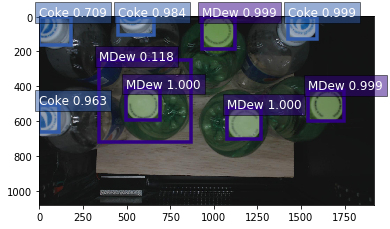

In [26]:
%matplotlib inline
object_categories = ['Coke','MDew']#,'MDew' ,'MDew']
threshold = 0.10
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

In [27]:
detections['prediction']

[[1.0,
  0.9998024106025696,
  0.2597428262233734,
  0.37893372774124146,
  0.35995152592658997,
  0.5505324602127075],
 [1.0,
  0.9995187520980835,
  0.5597944855690002,
  0.48671579360961914,
  0.6627079844474792,
  0.6518008708953857],
 [1.0,
  0.9992839694023132,
  0.4857800006866455,
  0.0015883594751358032,
  0.5847041606903076,
  0.17425033450126648],
 [1.0,
  0.9991775155067444,
  0.8028379678726196,
  0.3880109190940857,
  0.9086705446243286,
  0.5557438135147095],
 [0.0,
  0.998742401599884,
  0.7424451112747192,
  0.0,
  0.8292516469955444,
  0.12059211730957031],
 [0.0,
  0.9842133522033691,
  0.23456372320652008,
  0.0,
  0.34248703718185425,
  0.09644421190023422],
 [0.0,
  0.9633532166481018,
  0.0,
  0.4686412513256073,
  0.05975022539496422,
  0.6135149002075195],
 [0.0, 0.7094675302505493, 0.0, 0.0, 0.09383520483970642, 0.1498599797487259],
 [1.0,
  0.11761914193630219,
  0.17742560803890228,
  0.23275095224380493,
  0.4529111981391907,
  0.6652836799621582],
 [1.0,
 

In [28]:
######################################################################
############################   My version ############################
######################################################################
# tresh = 0.5
tresh = 0.5
tresh_iou = 0.5

bounding_boxes = []

for prediction in detections['prediction']:
    if prediction[1] >= tresh:
        #prediction = prediction[2:]
        bounding_boxes.append(prediction)
######################################################################
for idx, boundbox in enumerate(bounding_boxes):
    count =0
    for bb in bounding_boxes:
        check = get_iou(boundbox[2:],bb[2:])
        if check >= tresh_iou:
            count +=1
    if count>=3:
        bounding_boxes.remove(bounding_boxes[idx])
######################################################################       
print(len(bounding_boxes))

for boundbox in bounding_boxes:
    count = 0
    len_bounding_boxes = len(bounding_boxes)
    while count < len_bounding_boxes:
        if boundbox != bounding_boxes[count]:
            check = get_iou(boundbox[2:],bounding_boxes[count][2:])
            if check >= tresh_iou:
######################################################################                
                if boundbox[1] >= bounding_boxes[count][1]:
                    bounding_boxes.remove(bounding_boxes[count])
                else:
                    bounding_boxes.remove(boundbox)
######################################################################                    
#                 print("Item Deleted: {}".format(count))
                len_bounding_boxes -= 1
        
        # Raise Counter
        count += 1  

8


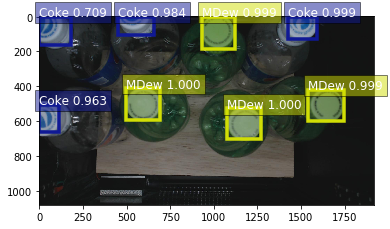

In [29]:
# object_categories = ['bottle']

# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.5
# Visualize the detections.
visualize_detection(file_name, bounding_boxes, object_categories, threshold)

In [164]:
bounding_boxes

[[0.0,
  0.9997360110282898,
  0.20965376496315002,
  0.2873615324497223,
  0.32340338826179504,
  0.4635181725025177],
 [0.0,
  0.9996681213378906,
  0.3906792998313904,
  0.43895769119262695,
  0.5090393424034119,
  0.6229547262191772],
 [0.0,
  0.9976024031639099,
  0.8244773745536804,
  0.005426518619060516,
  0.9368026852607727,
  0.1790088415145874],
 [0.0,
  0.9961657524108887,
  0.5091187953948975,
  0.10252756625413895,
  0.6157556772232056,
  0.27857038378715515],
 [1.0,
  0.9929608702659607,
  0.016256913542747498,
  0.037007927894592285,
  0.14590883255004883,
  0.20532789826393127],
 [1.0,
  0.9699695706367493,
  0.013024754822254181,
  0.43424275517463684,
  0.13074550032615662,
  0.6110895872116089],
 [1.0,
  0.6618933081626892,
  0.8345516324043274,
  0.47458094358444214,
  0.9455332159996033,
  0.64264315366745]]

1.jpg :


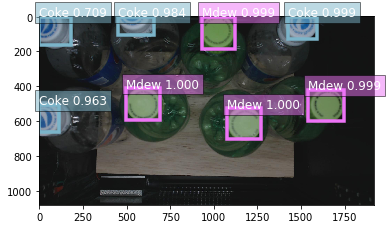

2.jpg :


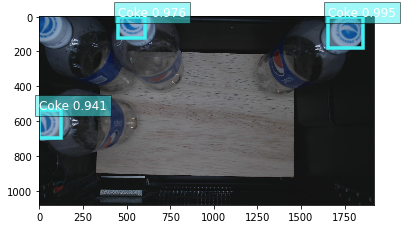

3.jpg :


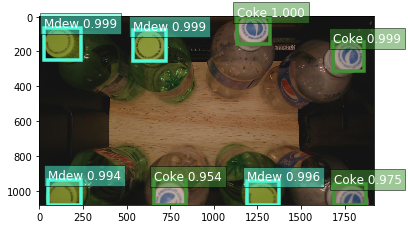

4.jpg :


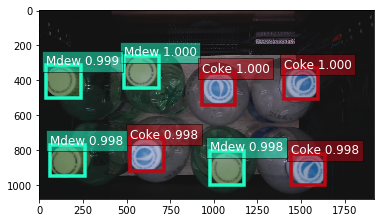

5.jpg :


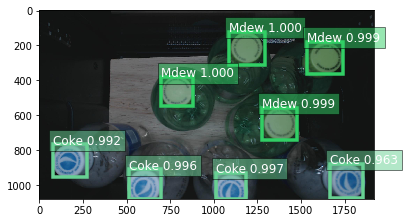

6.jpg :


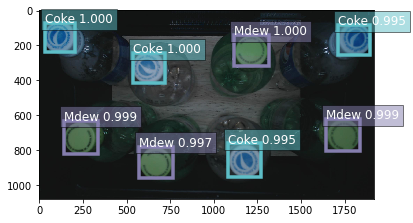

7.jpg :


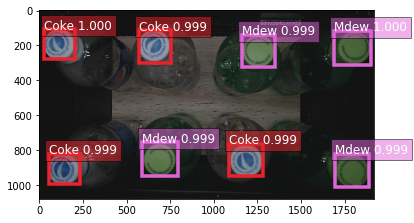

In [32]:
for i in range(1,8):
   # !wget -O test.jpg https://images.pexels.com/photos/980382/pexels-photo-980382.jpeg
# file_name = 'test.jpg'

    file_name = 'pepsi_new_folder/'+str(i)+'.jpg'


    # file_name = '6558DBD6-7B94-48F8-916F-1390F55DA21B.jpg'
    with open(file_name, 'rb') as image:
        f = image.read()
        b = bytearray(f)
        ne = open('n.txt','wb')
        ne.write(b)


    ############################################################################################################
    ###### .    DOING INFERENCE USING END-POINT that was just created   ########################################
    ############################################################################################################
    import json
    object_detector.content_type = 'image/jpeg'
    results = object_detector.predict(b)
    detections = json.loads(results)
    # print (detections)
#     print (detections)

    object_categories = ['Coke','Mdew']#,'MDew' ,'MDew']
    threshold = 0.10

    # tresh = 0.5
    tresh = 0.5
    tresh_iou = 0.5

    bounding_boxes = []

    for prediction in detections['prediction']:
        if prediction[1] >= tresh:
            #prediction = prediction[2:]
            bounding_boxes.append(prediction)

######################################################################
    for idx, boundbox in enumerate(bounding_boxes):
        count =0
        for bb in bounding_boxes:
            check = get_iou(boundbox[2:],bb[2:])
            if check >= tresh_iou:
                count +=1
        if count>=3:
            bounding_boxes.remove(bounding_boxes[idx])
######################################################################  
#     print(len(bounding_boxes))

    for boundbox in bounding_boxes:
        count = 0
        len_bounding_boxes = len(bounding_boxes)
        while count < len_bounding_boxes:
            if boundbox != bounding_boxes[count]:
                check = get_iou(boundbox[2:],bounding_boxes[count][2:])
                if check >= tresh_iou:
######################################################################                
                    if boundbox[1] >= bounding_boxes[count][1]:
                        bounding_boxes.remove(bounding_boxes[count])
                    else:
                        bounding_boxes.remove(boundbox)
###################################################################### 
                    len_bounding_boxes -= 1

            # Raise Counter
            count += 1  
        
        
    # object_categories = ['bottle']

    # Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
    threshold = 0.5
    # Visualize the detections.
    print(str(i)+'.jpg :')
    visualize_detection(file_name, bounding_boxes, object_categories, threshold) 

95.jpg :


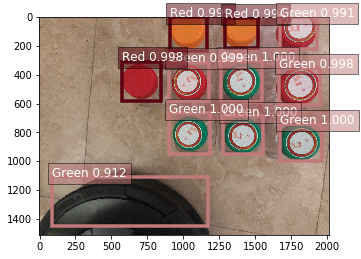

96.jpg :


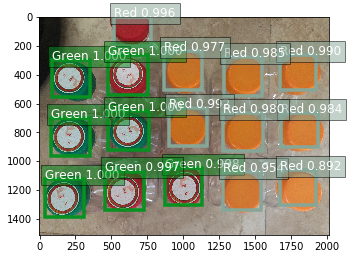

97.jpg :


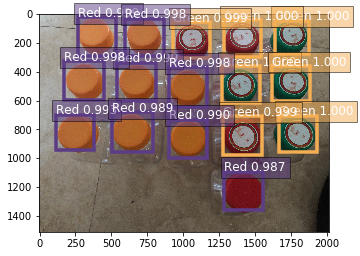

98.jpg :


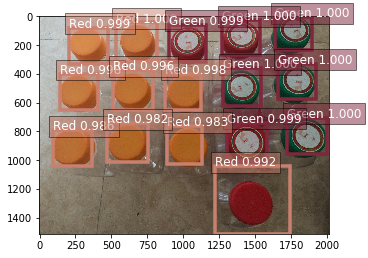

99.jpg :


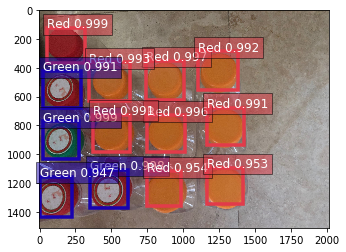

100.jpg :


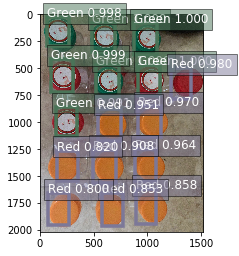

In [183]:
for i in range(95,101):
   # !wget -O test.jpg https://images.pexels.com/photos/980382/pexels-photo-980382.jpeg
# file_name = 'test.jpg'

    file_name = 'coolerpix_new/'+str(i)+'.jpg'


    # file_name = '6558DBD6-7B94-48F8-916F-1390F55DA21B.jpg'
    with open(file_name, 'rb') as image:
        f = image.read()
        b = bytearray(f)
        ne = open('n.txt','wb')
        ne.write(b)


    ############################################################################################################
    ###### .    DOING INFERENCE USING END-POINT that was just created   ########################################
    ############################################################################################################
    import json
    object_detector.content_type = 'image/jpeg'
    results = object_detector.predict(b)
    detections = json.loads(results)
    # print (detections)
#     print (detections)

    object_categories = ['Green','Red']#,'MDew' ,'MDew']
    threshold = 0.10

    # tresh = 0.5
    tresh = 0.5
    tresh_iou = 0.5

    bounding_boxes = []

    for prediction in detections['prediction']:
        if prediction[1] >= tresh:
            #prediction = prediction[2:]
            bounding_boxes.append(prediction)

######################################################################
    for idx, boundbox in enumerate(bounding_boxes):
        count =0
        for bb in bounding_boxes:
            check = get_iou(boundbox[2:],bb[2:])
            if check >= tresh_iou:
                count +=1
        if count>=3:
            bounding_boxes.remove(bounding_boxes[idx])
######################################################################  
#     print(len(bounding_boxes))

    for boundbox in bounding_boxes:
        count = 0
        len_bounding_boxes = len(bounding_boxes)
        while count < len_bounding_boxes:
            if boundbox != bounding_boxes[count]:
                check = get_iou(boundbox[2:],bounding_boxes[count][2:])
                if check >= tresh_iou:
######################################################################                
                    if boundbox[1] >= bounding_boxes[count][1]:
                        bounding_boxes.remove(bounding_boxes[count])
                    else:
                        bounding_boxes.remove(boundbox)
###################################################################### 
                    len_bounding_boxes -= 1

            # Raise Counter
            count += 1   
        
        
    # object_categories = ['bottle']

    # Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
    threshold = 0.5
    # Visualize the detections.
    print(str(i)+'.jpg :')
    visualize_detection(file_name, bounding_boxes, object_categories, threshold) 

In [ ]:
######################################################################
####################         LAMBDA modified        ###################
######################################################################
import json
import io
import os
import logging
import uuid
from concurrent.futures import ThreadPoolExecutor, wait, as_completed
import boto3
import image_utils
import base64
from PIL import Image
from datetime import datetime

sm = boto3.client('sagemaker-runtime', region_name='us-east-1')

logger = logging.getLogger()
logger.setLevel(logging.INFO)

SAGEMAKER_SSD_ENDPOINT = 'object-detection-2018-12-25-00-46-09-373'   #Conference

#SAGEMAKER_SSD_ENDPOINT = 'object-detection-2018-10-12-17-03-35-860'   #Pepsi
#object_categories = ['Green','Orange']
CONFIDENCE_THRESHOLD_SSD = 0.5
CONFIDENCE_THRESHOLD_IOU = 0.5


def gettime():
    dt = datetime.now()
    return(dt.microsecond)
    

def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    
    if intersection_area == bb1_area or intersection_area == bb1_area:
        return 1.0
    
    if intersection_area / bb1_area > 0.5  or intersection_area / bb2_area > 0.5:
        return 0.5

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou


def extract_bounding_boxes(image):
    
    # SageMaker should return the class string
    # to avoid managing IDs between APIs
    # or move to a conf file
    OBJECT_SHAPES = ['Orange','Green']

    response = sm.invoke_endpoint(
        EndpointName=SAGEMAKER_SSD_ENDPOINT,
        Body=image,
        ContentType='image/jpeg'
    )

    result = json.loads(response['Body'].read())

    #print(result)

    # list for bounding boxes
    bounding_boxes = []

    # Remove bounding boxes above the confidence ssd treshold 
    for prediction in result['prediction']:
        if prediction[1] >= CONFIDENCE_THRESHOLD_SSD:
            bounding_boxes.append(prediction)

    print("Bounding box quantity before NMS: {}".format(len(bounding_boxes)))

    # Loop to identify overcovering bounding boxes
######################################################################
    for idx, boundbox in enumerate(bounding_boxes):
        count =0
        for bb in bounding_boxes:
            check = get_iou(boundbox[2:],bb[2:])
            if check >= CONFIDENCE_THRESHOLD_SSD:
                count +=1
        if count>=3:
            bounding_boxes.remove(bounding_boxes[idx])
######################################################################  
    # Loop to identify overcovering bounding boxes
    for boundbox in reversed(bounding_boxes):
        count = 0
        len_bounding_boxes = len(bounding_boxes)
        while count < len_bounding_boxes:

            # If to not verify overcovering into the some bounding box
            if boundbox != bounding_boxes[count]:
                check = get_iou(boundbox[2:],bounding_boxes[count][2:])
                if check >= CONFIDENCE_THRESHOLD_IOU:
######################################################################                
                    if boundbox[1] >= bounding_boxes[count][1]:
                        bounding_boxes.remove(bounding_boxes[count])
                    else:
                        bounding_boxes.remove(boundbox)
######################################################################                     
                    len_bounding_boxes -= 1            
            # Raise Counter
            count += 1
                    
    #print(len(bounding_boxes))

    print("Bounding box quantity after NMS: {}".format(len(bounding_boxes)))

    items = []

    for p in bounding_boxes:
         (klass, score, x0, y0, x1, y1) = p

         if score < CONFIDENCE_THRESHOLD_SSD:
                continue
            
         photo = Image.open(io.BytesIO(image))
         shape = OBJECT_SHAPES[int(klass)]
         items.append({
            'product_id': shape,
            'object_detection_score': score,
            'position': image_utils.get_object_boundary_box(photo, (x0, y0, x1, y1))
        })


    logger.info('extract_bounding_boxes: {}'.format(items))
    
    return items
    


def lambda_handler(event, context):
    
    photo = event["img"]
    photo = base64.b64decode(photo)
    image = Image.open(io.BytesIO(photo))
    bounding_boxes = extract_bounding_boxes(photo)

    return {
        "statusCode": 200,
        "body": json.dumps(bounding_boxes)
    }



In [ ]:
######################################################################
####################         LAMBDA original        ###################
######################################################################

import json
import io
import os
import logging
import uuid
from concurrent.futures import ThreadPoolExecutor, wait, as_completed
import boto3
import image_utils
import base64
from PIL import Image
from datetime import datetime

sm = boto3.client('sagemaker-runtime', region_name='us-east-1')

logger = logging.getLogger()
logger.setLevel(logging.INFO)

SAGEMAKER_SSD_ENDPOINT = 'object-detection-2018-12-16-19-54-26-470'   #Conference

#SAGEMAKER_SSD_ENDPOINT = 'object-detection-2018-10-12-17-03-35-860'   #Pepsi
#object_categories = ['Green','Orange']
CONFIDENCE_THRESHOLD_SSD = 0.5
CONFIDENCE_THRESHOLD_IOU = 0.5


def gettime():
    dt = datetime.now()
    return(dt.microsecond)
    

def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    
    if intersection_area == bb1_area or intersection_area == bb1_area:
        return 1.0
    
    if intersection_area / bb1_area > 0.5  or intersection_area / bb2_area > 0.5:
        return 0.5

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou


def extract_bounding_boxes(image):
    
    # SageMaker should return the class string
    # to avoid managing IDs between APIs
    # or move to a conf file
    OBJECT_SHAPES = ['Orange','Green']

    response = sm.invoke_endpoint(
        EndpointName=SAGEMAKER_SSD_ENDPOINT,
        Body=image,
        ContentType='image/jpeg'
    )

    result = json.loads(response['Body'].read())

    #print(result)

    # list for bounding boxes
    bounding_boxes = []

    # Remove bounding boxes above the confidence ssd treshold 
    for prediction in result['prediction']:
        if prediction[1] >= CONFIDENCE_THRESHOLD_SSD:
            bounding_boxes.append(prediction)

    print("Bounding box quantity before NMS: {}".format(len(bounding_boxes)))

    # Loop to identify overcovering bounding boxes
    for boundbox in reversed(bounding_boxes):
        count = 0
        len_bounding_boxes = len(bounding_boxes)
        while count < len_bounding_boxes:

            # If to not verify overcovering into the some bounding box
            if boundbox != bounding_boxes[count]:
                check = get_iou(boundbox[2:],bounding_boxes[count][2:])
                if check >= CONFIDENCE_THRESHOLD_IOU:
                    
                    # Bad Model - Small Boxes
                    boundboxX = boundbox[5] - boundbox[3] 
                    #print(boundboxX)
                    boundboxXCount = bounding_boxes[count][5] - bounding_boxes[count][3]
                    #print(boundboxXCount)
                    
                    if boundboxX < boundboxXCount:
                        print("Removing: " + str(boundboxXCount))
                        bounding_boxes.remove(bounding_boxes[count])

                    else:
                        print("Removing: " + str(boundboxX))
                        bounding_boxes.remove(boundbox)
                        break
                    
                    # Good Model
                    #bounding_boxes.remove(bounding_boxes[count])
                    #print("Item Deleted: {}".format(count))
                    
                    #print("Item Deleted: {}".format(count))
                    len_bounding_boxes -= 1
            
            # Raise Counter
            count += 1
                    
    #print(len(bounding_boxes))

    print("Bounding box quantity after NMS: {}".format(len(bounding_boxes)))

    items = []

    for p in bounding_boxes:
         (klass, score, x0, y0, x1, y1) = p

         if score < CONFIDENCE_THRESHOLD_SSD:
                continue
            
         photo = Image.open(io.BytesIO(image))
         shape = OBJECT_SHAPES[int(klass)]
         items.append({
            'product_id': shape,
            'object_detection_score': score,
            'position': image_utils.get_object_boundary_box(photo, (x0, y0, x1, y1))
        })


    logger.info('extract_bounding_boxes: {}'.format(items))
    
    return items
    


def lambda_handler(event, context):
    
    photo = event["img"]
    photo = base64.b64decode(photo)
    image = Image.open(io.BytesIO(photo))
    bounding_boxes = extract_bounding_boxes(photo)

    return {
        "statusCode": 200,
        "body": json.dumps(bounding_boxes)
    }

